In [1]:
# import required libraries
import warnings
warnings.filterwarnings("ignore")

# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# Library to split data
from sklearn.model_selection import train_test_split

# Libraries to help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To enable plotting graphs in Jupyter notebook
%matplotlib inline 

# Removes the limit from the number of displayed columns and rows.
pd.set_option("display.max_columns", None)
# pd.set_option('display.max_rows', None)
pd.set_option("display.max_rows", 200)

# for statistical analysis 
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


# To get diferent metric scores
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve, f1_score
from sklearn.model_selection import GridSearchCV

## Load and Review Data

In [2]:
# Loading the dataset
data = pd.read_csv("Loan_Modelling.csv")

# copying data to another variable to avoid any changes to original data
df_customers=data.copy()

# print number of columns and rows in data frame
print("(rows, columns) =", df_customers.shape)

# view top 5 rows of data
df_customers.head()

(rows, columns) = (5000, 14)


,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [3]:
# view bottom 5 rows of data
df_customers.tail()

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
4995,4996,29,3,40,92697,1,1.9,3,0,0,0,0,1,0
4996,4997,30,4,15,92037,4,0.4,1,85,0,0,0,1,0
4997,4998,63,39,24,93023,2,0.3,3,0,0,0,0,0,0
4998,4999,65,40,49,90034,3,0.5,2,0,0,0,0,1,0
4999,5000,28,4,83,92612,3,0.8,1,0,0,0,0,1,1


In [4]:
# Check the data types of the columns for the dataset
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIPCode             5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal_Loan       5000 non-null   int64  
 10  Securities_Account  5000 non-null   int64  
 11  CD_Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


* Dependent variable is Personal_Loan (1: customer accepted the offer, 0: customer ddidn't accept)
* There are no missing values in the dataset
* There are total 14 columns and 5,000 observations in the dataset

In [5]:
# checking for unique values in ID & ZIPCode columns
df_customers[["ID","ZIPCode"]].nunique()

ID         5000
ZIPCode     467
dtype: int64

Since all the values in ID column are unique we can drop it:

In [6]:
df_customers.drop(["ID"],axis=1,inplace=True)

In [7]:
# check the number of unique values in each column
df_customers.nunique()

Age                    45
Experience             47
Income                162
ZIPCode               467
Family                  4
CCAvg                 108
Education               3
Mortgage              347
Personal_Loan           2
Securities_Account      2
CD_Account              2
Online                  2
CreditCard              2
dtype: int64

- Age has only 45 unique values i.e. most of the customers are of similar age
- We have only four continuous variables - Age, Experience, Income, CCAvg, and Mortgage
- All other variables are categorical

In [8]:
# Let's take a closer look at zip code
df_customers["ZIPCode"].describe()

count     5000.000000
mean     93169.257000
std       1759.455086
min      90005.000000
25%      91911.000000
50%      93437.000000
75%      94608.000000
max      96651.000000
Name: ZIPCode, dtype: float64

- A simple search from map we may find out that the ZIP codes are all from California, where the smaller values are from the southern California nearer to Los Angeles, while the larger values are from the northern California nearer to San Franscisco.
- There are 467 unique ZIPCode values in our datasset. We can reduce them to their respective regions, namely Northern, Middle and Southern California

In [9]:
# Create a new variable - Region
df_customers["ZIPCode"] = pd.cut(
    x=df_customers["ZIPCode"],
    bins=[90000, 92233, 94467, 96700],
    labels=["Southern_California", "Middle_California", "Northern_California"],
)

# Rename the column as Region
df_customers.rename(columns={"ZIPCode": "Region"}, inplace=True)
df_customers["Region"].value_counts()

Southern_California    1802
Middle_California      1647
Northern_California    1551
Name: Region, dtype: int64

In [10]:
# Making a list of catrgorical variables (we exclude ZIPCode from the list for now)
cat_col = [
    "Region",
    "Family",
    "Education",
    "Securities_Account",
    "CD_Account",
    "Online",
    "CreditCard",
    "Personal_Loan"
]

# Making a list of all continuous variables
con_col = [
    "Age",
    "Experience",
    "Income",
    "CCAvg",
    "Mortgage"
]

In [11]:
# Printing number of count of each unique value in each column
for column in cat_col:
    print(df_customers[column].value_counts())
    print("-" * 50)

Southern_California    1802
Middle_California      1647
Northern_California    1551
Name: Region, dtype: int64
--------------------------------------------------
1    1472
2    1296
4    1222
3    1010
Name: Family, dtype: int64
--------------------------------------------------
1    2096
3    1501
2    1403
Name: Education, dtype: int64
--------------------------------------------------
0    4478
1     522
Name: Securities_Account, dtype: int64
--------------------------------------------------
0    4698
1     302
Name: CD_Account, dtype: int64
--------------------------------------------------
1    2984
0    2016
Name: Online, dtype: int64
--------------------------------------------------
0    3530
1    1470
Name: CreditCard, dtype: int64
--------------------------------------------------
0    4520
1     480
Name: Personal_Loan, dtype: int64
--------------------------------------------------


- There are quite a good mix of customers from different regions, with most of them are from Southern_California;
- Most customers have a family size of 1;
- Most customers are undergrad;
- Majority of the customers don't have securities account nor certificate of deposit with the bank;
- There are more customers use internet banking facilities than those who don't;
- Majority of the customers never use any credit card issued by other bank than those who do not.

In [12]:
# Calculate Personal_Loan ratio of Yes/No from outcome variable
n_yes = len(df_customers.loc[df_customers['Personal_Loan'] == 1])
n_no = len(df_customers.loc[df_customers['Personal_Loan'] == 0])
print("No. of customers accepted personal loan: {0} ({1:2.2f}%)".format(
    n_yes, (n_yes / (n_yes + n_no)) * 100 ))
print("No. of customers didn't accept personal loan: {0} ({1:2.2f}%)".format(
   n_no, (n_no / (n_yes + n_no)) * 100))

No. of customers accepted personal loan: 480 (9.60%)
No. of customers didn't accept personal loan: 4520 (90.40%)


- We only have 9.60% of customers in current data set who accepted the personal loan offered in the last campaign, and rest of 90.40% didn't accept.
- This dataset is imbalanced. Our algorithm might end up learning most features of customers who didn't accept personal loans instead of those who would accept.

In [13]:
# view summary of continous variables
df_customers[con_col].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,5000.0,45.338400,11.463166,23.0,35.0,45.0,55.0,67.0
Experience,5000.0,20.104600,11.467954,-3.0,10.0,20.0,30.0,43.0
Income,5000.0,73.774200,46.033729,8.0,39.0,64.0,98.0,224.0
CCAvg,5000.0,1.937938,1.747659,0.0,0.7,1.5,2.5,10.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.0,0.0,101.0,635.0


- Mean value for the age column is approx 45 and median is 45. This shows that majority of the customers are around the age of 45 years old;
- Mean and median value for the experience column are also close to each other at 20. This shows that majority of the customers are around have 20 years of professional experience;
- Notice that the minimum value of experience is -3, which is an anomaly (because its value cannot be negative);
- The monthly average spending on credit cards is ranging from zero dollar to ten thousand dollars;
- Mean value of Mortgage is $56.5K while its median is 0, which indicates that its distribution is highly skewed.

## Univariate Analysis

In [14]:
# While doing uni-variate analysis of numerical variables we want to study their central tendency 
# and dispersion.
# Let us write a function that will help us create boxplot and histogram for any input numerical 
# variable.
# This function takes the numerical column as the input and returns the boxplots 
# and histograms for the variable.
# Let us see if this help us write faster and cleaner code.
def histogram_boxplot(feature, figsize=(15,10), bins = None):
    """ Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    sns.set(font_scale=2) # setting the font scale  of the seaborn
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           ) # creating the 2 subplots
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='violet') # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(feature, kde=F, ax=ax_hist2, bins=bins,color = 'orange') if bins else sns.distplot(feature, kde=False, ax=ax_hist2, color='tab:cyan') # For histogram
    ax_hist2.axvline(np.mean(feature), color='purple', linestyle='--') # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='black', linestyle='-') # Add median to the histogram

In [15]:
con_col

['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage']

#### Observations on Age: 

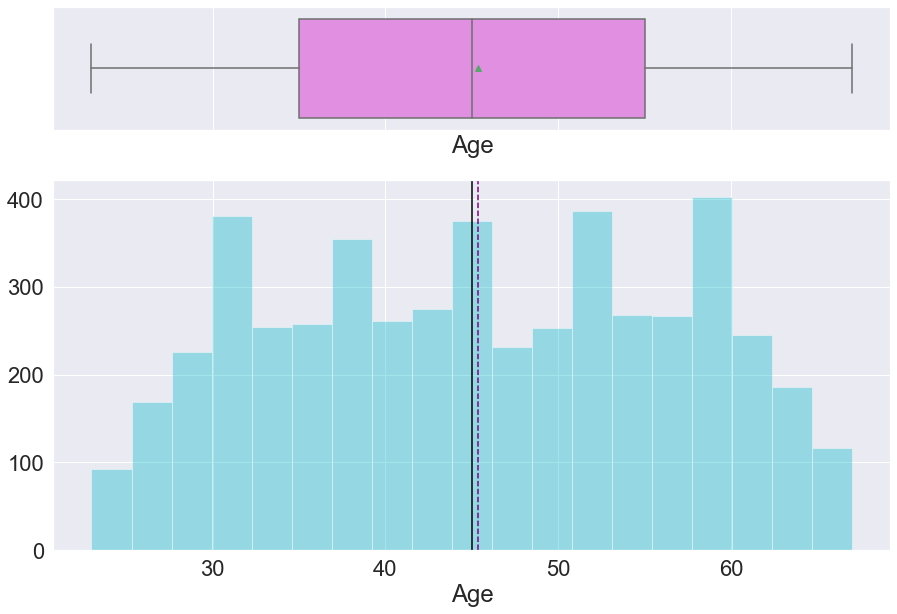

In [16]:
histogram_boxplot(df_customers["Age"])

- The median and mean age approximate 45 years old;
- The boxplot shows that there aren't any outliers;
- The median and average age is about 45 years old.

#### Observations on Experience:

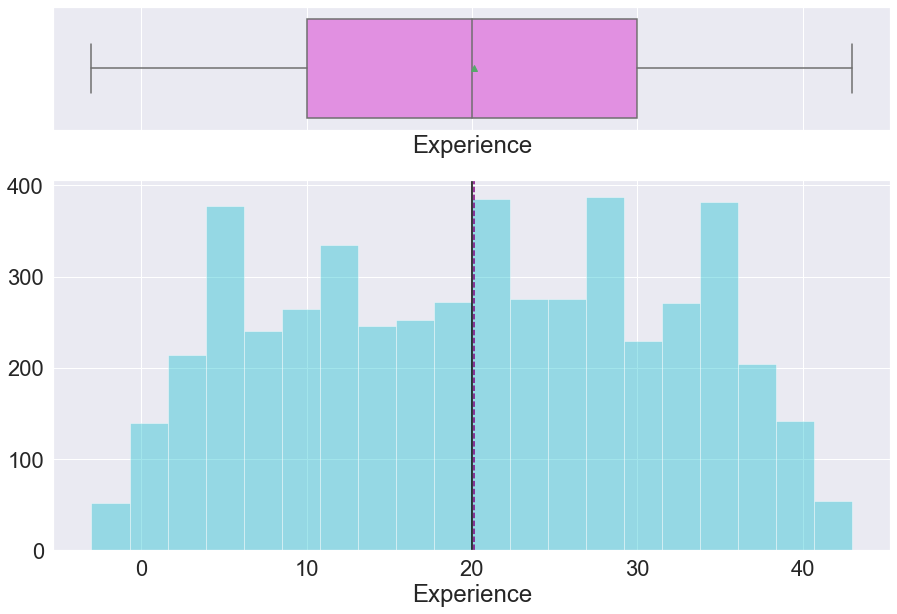

In [17]:
histogram_boxplot(df_customers["Experience"])

- The median and average years of experience is 20 years;
- The boxplot shows that there aren't any outliers;
- But from earlier analysis we found out that there are some negative values which need to be treated.

#### Observations on Income:

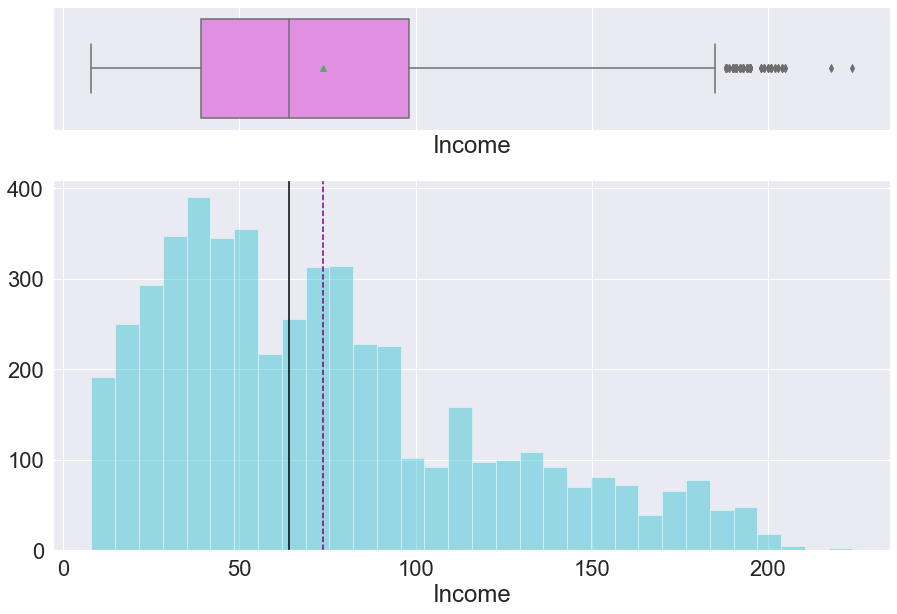

In [18]:
histogram_boxplot(df_customers["Income"])

- The distribution of income is right skewed;
- The avarage income of customers is about $70,000;
- The boxplot shows that there are outliers at the right end;
- We will treat these outliers for better performance of Logistic Regression.

#### Observations on CCAvg:

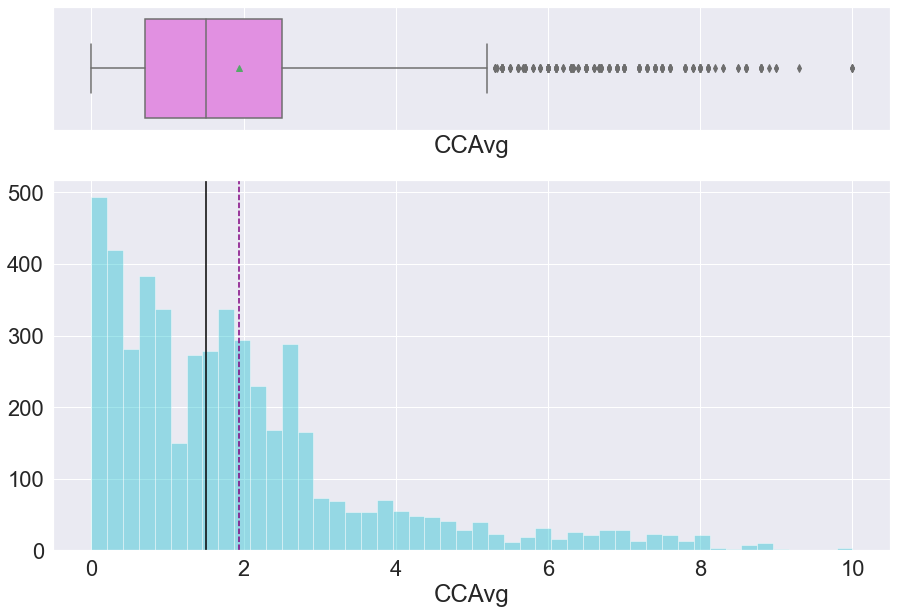

In [19]:
histogram_boxplot(df_customers["CCAvg"])

- The distribution of CCAvg is right skewed;
- The mean value of monthly average spending on credit cards is about $1,930;
- The boxplot shows that there are outliers at the right end;
- We will treat these outliers for better performance of Logistic Regression.

#### Observations on Mortgage:

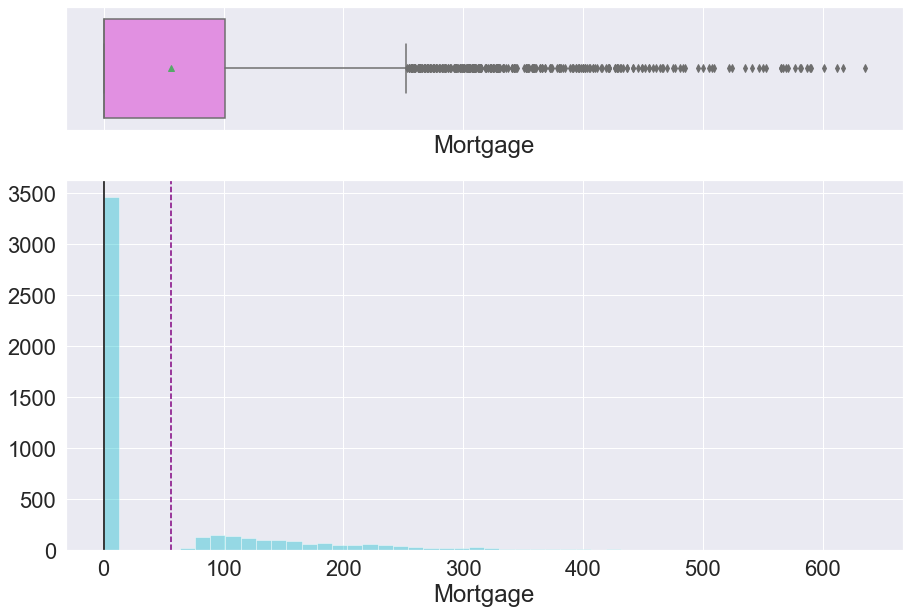

In [20]:
histogram_boxplot(df_customers["Mortgage"])

- Mortgage is extremely right-skewed.
- Most of the data is concentrated at zero, and there seems to be no observation between zero and $50,000;
- This is likely because most customers do not have any mortgage, and if they do, the morgage value would be a large sum;
- We will not treat these outliers as they represent the real market trend;
- We will perform Log transformation on this variable.

In [21]:
# Function to create barplots that indicate percentage for each category.

def perc_on_bar(feature):
    '''
    plot
    feature: categorical feature
    the function won't work if a column is passed in hue parameter
    '''

    total = len(feature) # length of the column
    plt.figure(figsize=(10, 5))
    ax = sns.countplot(feature,palette='Paired')
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total) # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - 0.05 # width of the plot
        y = p.get_y() + p.get_height()           # hieght of the plot        
        ax.annotate(percentage, (x, y), size = 12) # annotate the percantage 
    plt.show() # show the plot

#### Observations on where the customers live at:

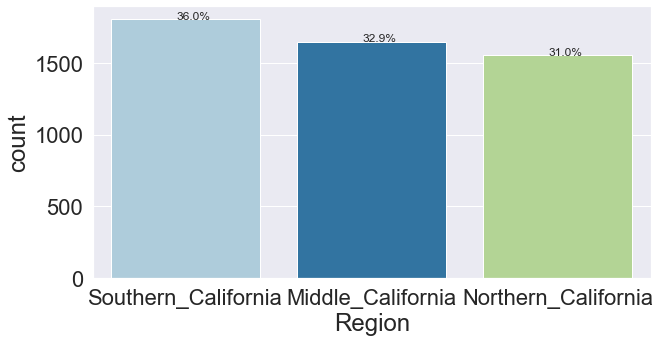

In [22]:
perc_on_bar(df_customers["Region"])

- 36% of customers are from southern California, followed by 32.9% of customers from middle region of california, and 31% of customers from northern California. 

#### Observations on the family size of customers:

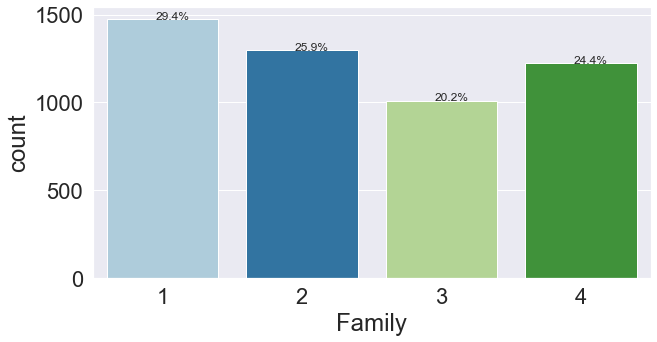

In [23]:
perc_on_bar(df_customers["Family"])

- 29.4% of customers have a family size of 1, followed by 25.9% of customers having a family size of 2, and then 24.4% with a family size of 4, and lastly only 20.2% of customers have a family size of 3.

#### Observations on education level of customers:

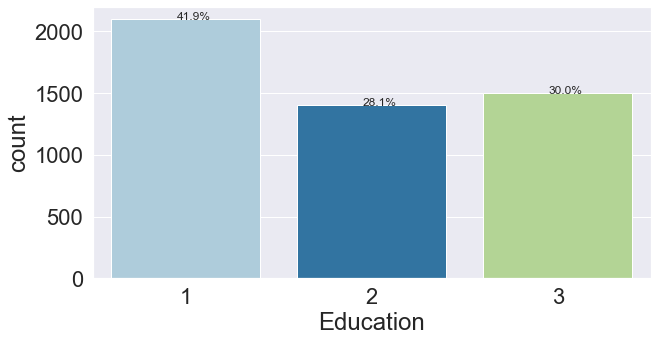

In [24]:
perc_on_bar(df_customers["Education"])

- While we have a good mix of customers from each of the three education levels, most of them are Undergrad, which constitutes nearly 42% of the dataset.

#### Observations on whether the customer has securities  account with the bank:

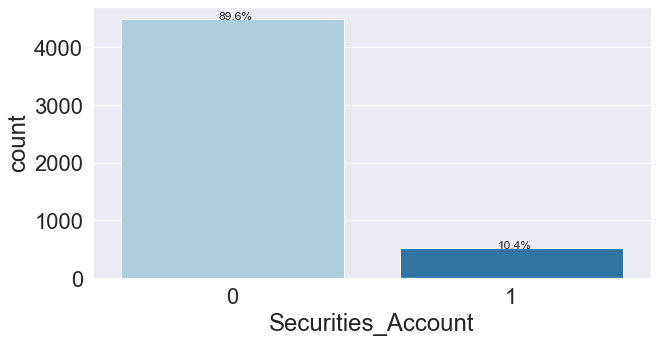

In [25]:
perc_on_bar(df_customers["Securities_Account"])

- Nearly 90% of customers don't have securities account with the bank.

#### Observations on whether the customer has a certificate of deposit (CD) account with the bank:

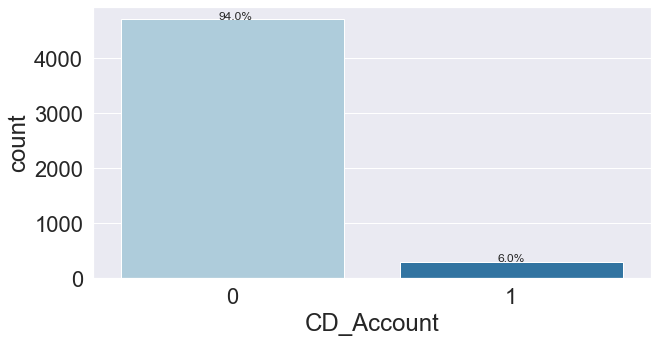

In [26]:
perc_on_bar(df_customers["CD_Account"])

- Nearly 94% of customers don't have any certificate of deposit (CD) account with the bank.

#### Observations on whether the customer  use internet banking facilities:

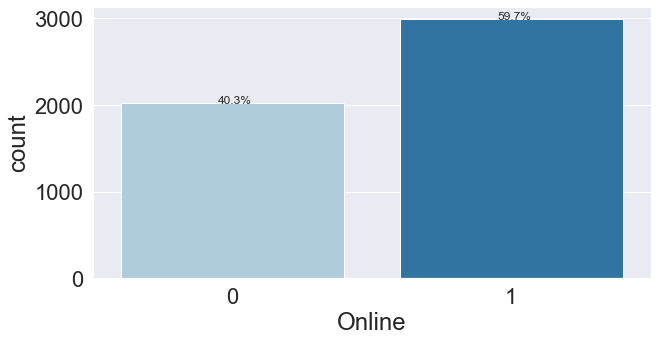

In [27]:
perc_on_bar(df_customers["Online"])

- There are more customers use internet banking facilities than those who don't.

#### Observations on whether the customer use a credit card issued by any other Bank:

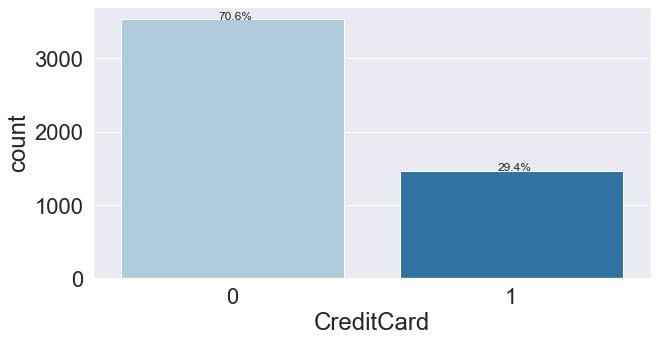

In [28]:
perc_on_bar(df_customers["CreditCard"])

- There are approximatelt 70.6% customers never use any credit card issued by some other bank.

#### Observations on whether the customer accepted personal loan:

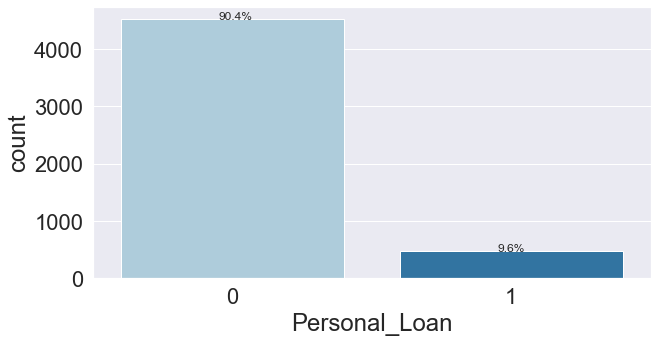

In [29]:
perc_on_bar(df_customers["Personal_Loan"])

- As mentioned earlier, the class distribution in the target variable is imbalanced.
- We have 90.4% observations for customers who didn't accept the personal loan offered and only 9.6% observations for customers who did accept.

## Bivariate Analysis

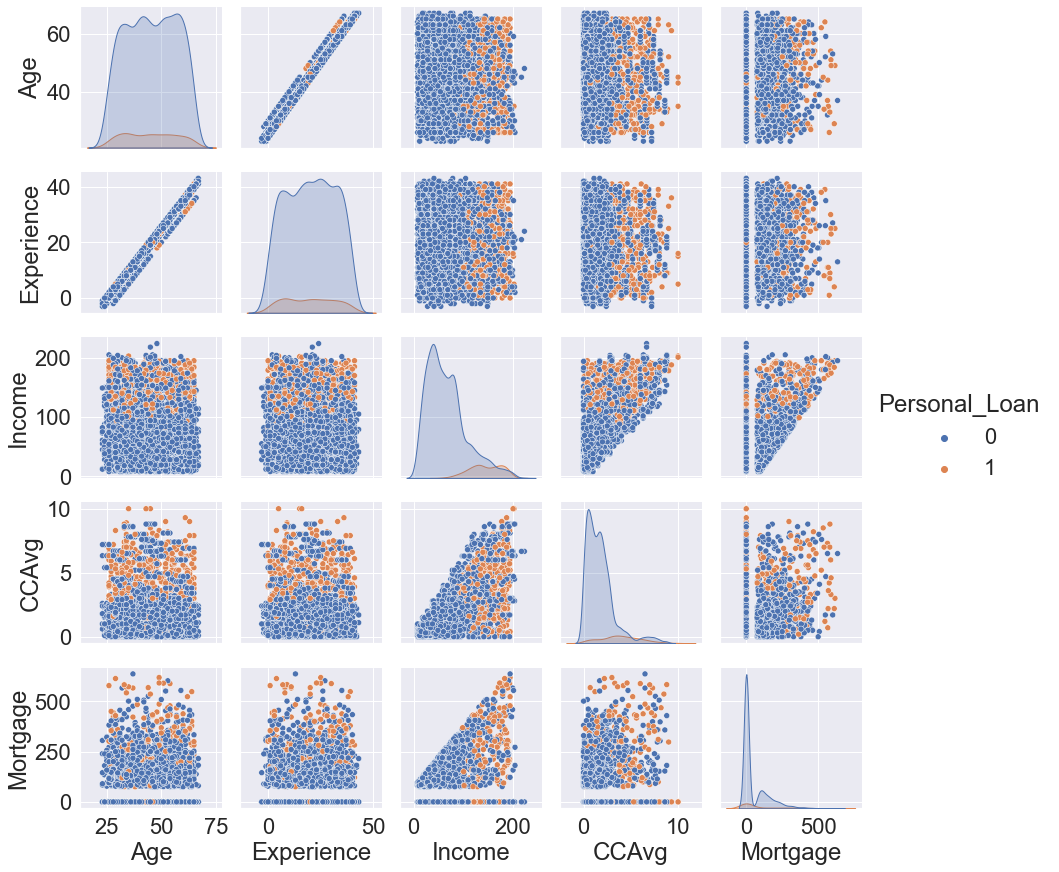

In [30]:
# check the linear relationships of numerical variables
con_col.append("Personal_Loan") #add "Personal_Loan" into continous column list to plot with  hue parameter
sns.pairplot(df_customers[con_col],hue="Personal_Loan");

- Some pairs of variables have no linear relationship at all, such as Income vs Experience;
- Generally, customers with higher income tend to spend more on credit cards, even though there are some customers with equally high income spend lesser than others. We may however notice that customers with low income are being capped on their spending limit on credit cards, which are in correspond to their income;
- We could also notice that customers with higher income and customers who spend more on credit cards tend to accept the personal loans;
- Sighted that Age and Experiece variables are linearly correlated.

Let's take a closer look at their correlation via heatmap:

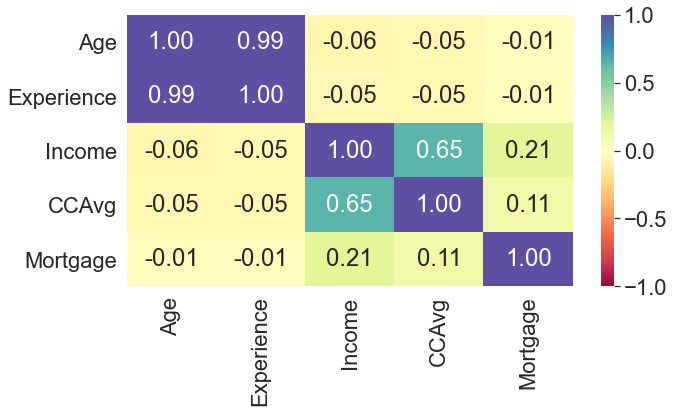

In [31]:
con_col.remove("Personal_Loan") # remove the target variable for a better view

plt.figure(figsize=(10,5))
sns.heatmap(df_customers[con_col].corr(),annot=True,vmin=-1,vmax=1,fmt='.2f',cmap='Spectral');

- We confirm that Age and Experience have a very high correlation relationship, thus we can drop either one of them.
- Recalling from earlier analysis we are aware that Experience has negative values. Hence, it would be advisable to drop Experience column.

In [32]:
# drop 'Experience'
df_customers.drop("Experience", axis=1, inplace=True)

**Let's explore this further with the help of other plots:**

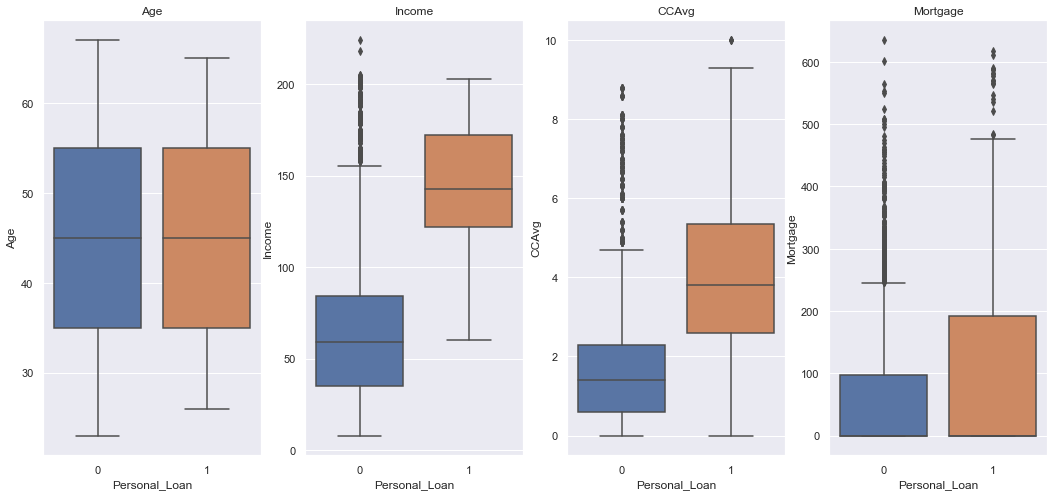

In [33]:
con_col.remove("Experience") #remove "Experience" from coninuous column list

sns.set(rc={"figure.figsize": (18, 8)})
for i, variable in enumerate(con_col):
    plt.subplot(1,len(con_col),i+1)    
    sns.boxplot(x="Personal_Loan", y=variable, data=df_customers, orient="vertical")
    plt.title(variable)                   
plt.show()

- Firstly, we can see that both customers who accepted and didn't accept personal loans are of similar age.
- Secondly, csutomers who accepted personal loans generally have much higher income than those who didn't. There are outliers in boxplots of customers who didn't accept personal loans. In other words, some customers who earned high income didn't accept personal loans.
- Thirdly, customers who accepted personal loans also have higher monthly average spending on credit cards.
- Forthly, third quartile mortgage value of customers who accepted personal loans is about double of the third quartile mortgage value of custeomers who didn't accept personal loans. Besides, there are more outliers of mortgage values in the distribution of customers who didn't accept personal loans.

In [34]:
## Function to plot stacked bar chart
def stacked_plot(x):
    sns.set(palette="nipy_spectral")
    tab1 = pd.crosstab(x, df_customers["Personal_Loan"], margins=True)
    print(tab1)
    print("-" * 110)
    tab = pd.crosstab(x, df_customers["Personal_Loan"], normalize="index")
    tab.plot(kind="bar", stacked=True, figsize=(15, 5))
    plt.show()

#### Personal_Loan vs Region:

Personal_Loan           0    1   All
Region                              
Southern_California  1623  179  1802
Middle_California    1499  148  1647
Northern_California  1398  153  1551
All                  4520  480  5000
--------------------------------------------------------------------------------------------------------------


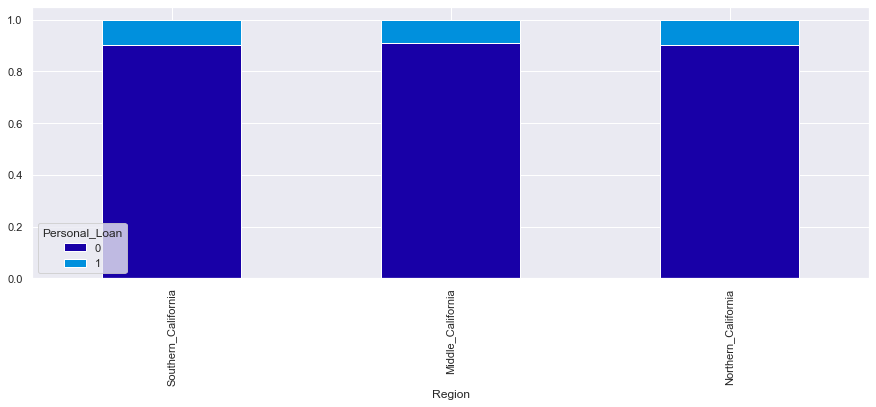

In [35]:
stacked_plot(df_customers["Region"])

- There are nearly about the same percentage of customers from all three regions accepted personal loans.

#### Personal_Loan vs Family:

Personal_Loan     0    1   All
Family                        
1              1365  107  1472
2              1190  106  1296
3               877  133  1010
4              1088  134  1222
All            4520  480  5000
--------------------------------------------------------------------------------------------------------------


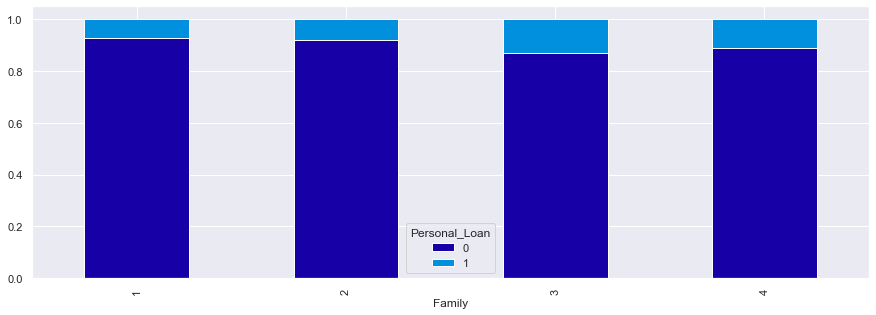

In [36]:
stacked_plot(df_customers["Family"])

- Customers with family size of 3 are relatively the most likely to accept personal loan than other grous, followed by customers with family size of 4.
- Less than 10% of customers with family size of 1 and 2 accepted personal loans.

#### Personal_Loan vs Education:

Personal_Loan     0    1   All
Education                     
1              2003   93  2096
2              1221  182  1403
3              1296  205  1501
All            4520  480  5000
--------------------------------------------------------------------------------------------------------------


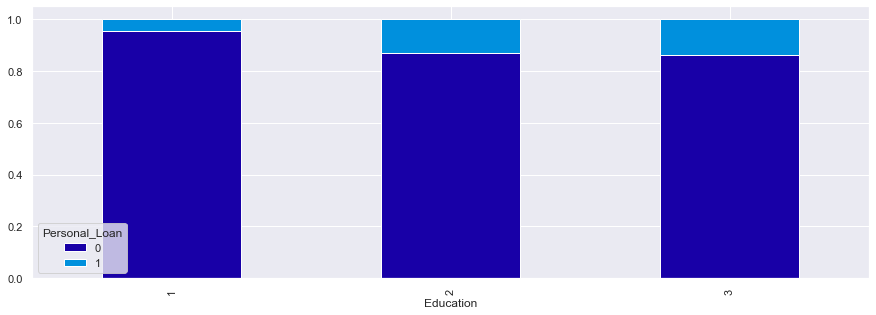

In [37]:
stacked_plot(df_customers["Education"])

- Advanced/Professionals are most likely to accept personal loan, followed by Graduates who in turn are more likely than accept personal loan as compared with Undergrads.

#### Personal_Loan vs Securities_Account:

Personal_Loan          0    1   All
Securities_Account                 
0                   4058  420  4478
1                    462   60   522
All                 4520  480  5000
--------------------------------------------------------------------------------------------------------------


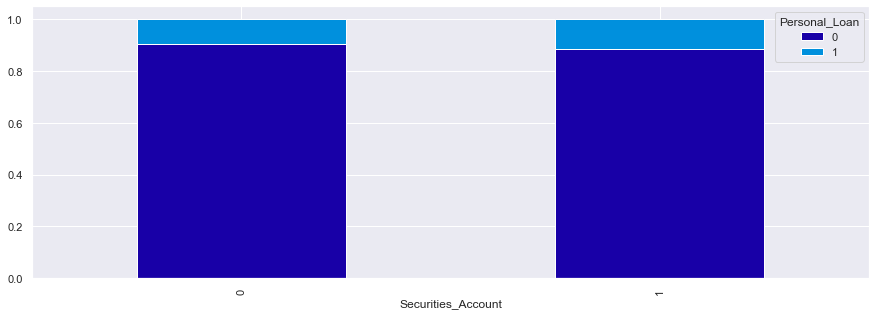

In [38]:
stacked_plot(df_customers["Securities_Account"])

* Customers who have a securities account with AllLife bank are only slightly more likely (~11%) than those who don't have securities account with the bank to accept personal loans.

#### Personal_Loan vs CD_Account:

Personal_Loan     0    1   All
CD_Account                    
0              4358  340  4698
1               162  140   302
All            4520  480  5000
--------------------------------------------------------------------------------------------------------------


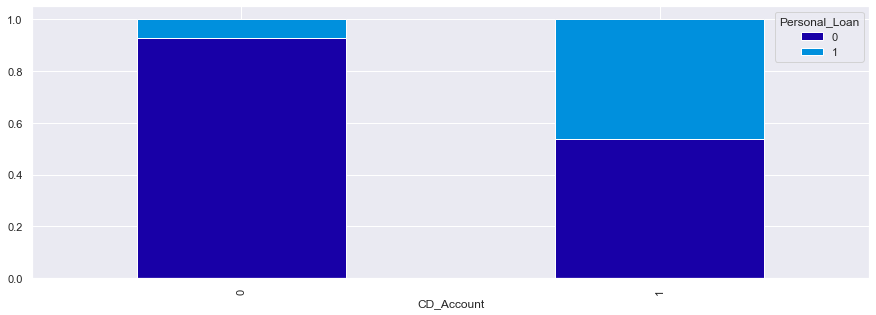

In [39]:
stacked_plot(df_customers["CD_Account"])

- Customers who have a certificate of deposit (CD) account with AllLife bank are much more likely to accept personal loans. This is probably because this group of customers feel confident to be able to repay.

#### Personal_Loan vs Online:

Personal_Loan     0    1   All
Online                        
0              1827  189  2016
1              2693  291  2984
All            4520  480  5000
--------------------------------------------------------------------------------------------------------------


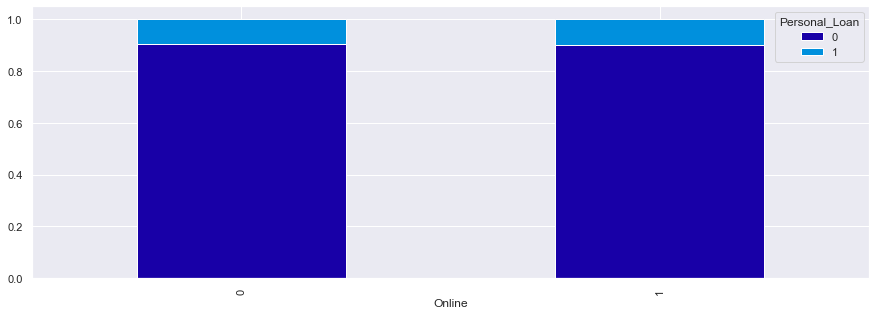

In [40]:
stacked_plot(df_customers["Online"])

- There are about 9.5% of customers who never use internet banking facilities and 10% of those who use internet banking facilities accepted personal loan offerred by AllLife Bank.

#### Personal_Loan vs Using a CreditCard of other bank:

Personal_Loan     0    1   All
CreditCard                    
0              3193  337  3530
1              1327  143  1470
All            4520  480  5000
--------------------------------------------------------------------------------------------------------------


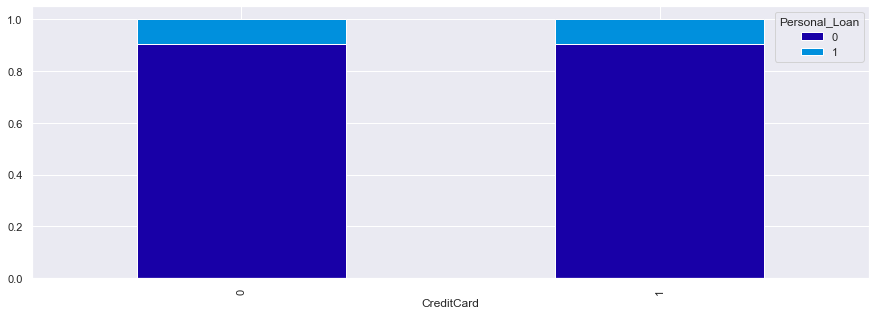

In [41]:
stacked_plot(df_customers["CreditCard"])

- It appears that there are equally ~9.5% of customers with or without using any credit card of other bank accepted personal loan offerred by AllLife Bank.

## Data Pre-Processing

In [42]:
# Use One-Hot Encoding for the other Region column
df_customers = pd.get_dummies(df_customers, columns=["Region"], drop_first=True)
df_customers.head()

,Age,Income,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,Region_Middle_California,Region_Northern_California
0,25,49,4,1.6,1,0,0,1,0,0,0,0,0
1,45,34,3,1.5,1,0,0,1,0,0,0,0,0
2,39,11,1,1.0,1,0,0,0,0,0,0,0,1
3,35,100,1,2.7,2,0,0,0,0,0,0,1,0
4,35,45,4,1.0,2,0,0,0,0,0,1,0,0


In [43]:
# duplicate the data so that we can use df_customers for Decision Tree, 
# because Decision Tree performs well on skewed data and also does not require scaling of data 
df_customers2 = df_customers.copy()

- From earlier analysis we confirmed that the columns "Income", "CCAvg", and "Mortgage" do not have non-positive values;
- Let's perform Log transformation on these skewed columns:

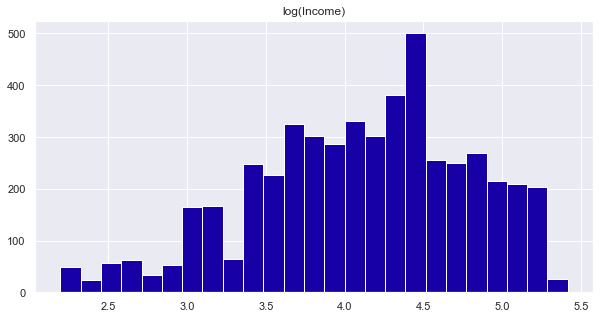

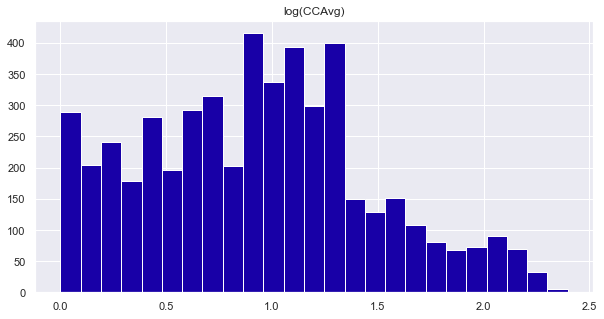

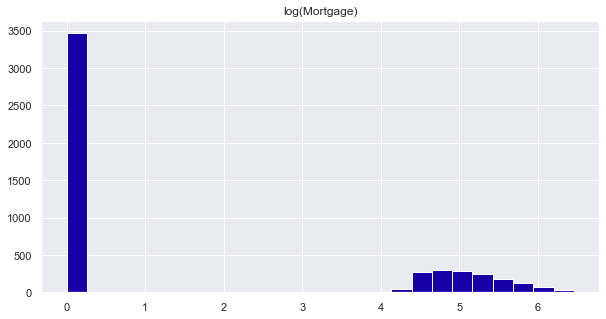

In [44]:
col_skewed = ["Income", "CCAvg", "Mortgage"]
for colname in col_skewed:
    plt.figure(figsize=(10, 5))
    df_customers2[colname] = np.log1p(df_customers2[colname])
    df_customers2.rename(columns={colname: f"{colname}_log"}, inplace=True)
    plt.hist(df_customers2[f"{colname}_log"], 25)
    plt.title(f"log({colname})")
    plt.show()

In [45]:
from sklearn.preprocessing import MinMaxScaler

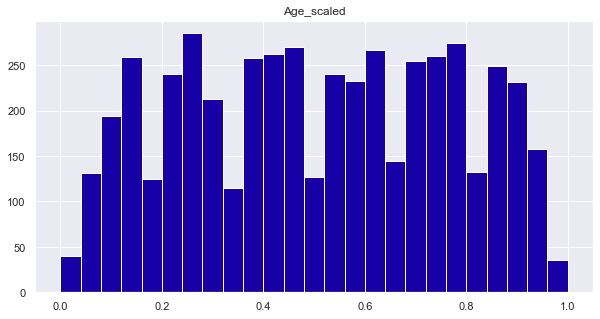

In [46]:
# replacing Age column with scaled 

df_customers2["Age"] = MinMaxScaler().fit_transform(df_customers2[["Age"]])
df_customers2.rename(columns={"Age": "Age_scaled"}, inplace=True)
plt.figure(figsize=(10,5))
df_customers2["Age_scaled"].hist(bins=25)
plt.title("Age_scaled")
plt.show()

# since the minimum and maximum are treated as fixed, this is also a linear transformation
# so the shape is the same

#### Treating Outliers:

- There are some outliers in the data which we will treat (perform capping of outliers);
- From earlier analysis we found out that the outliers are all above the upper whisker of boxplots;
- We assign the value of the upper whisker to all the values above the upper whisker;
- The columns we are targeting to treat outliers incluse "Income" and "CCAvg".

In [47]:
def treat_outliers(data,col):
    '''
    treats outliers in a varaible
    col: str, name of the numerical varaible
    data: data frame
    col: name of the column
    '''
    Q1=data[col].quantile(0.25) # 25th quantile
    Q3=data[col].quantile(0.75)  # 75th quantile
    IQR=Q3-Q1
    Lower_Whisker = Q1 - 1.5*IQR 
    Upper_Whisker = Q3 + 1.5*IQR
    data[col] = np.clip(data[col], Lower_Whisker, Upper_Whisker) # all the values smaller than Lower_Whisker will be assigned value of Lower_whisker 
                                                            # and all the values above upper_whisker will be assigned value of upper_Whisker 
    return data

def treat_outliers_all(data, col_list):
    '''
    treat outlier in all numerical varaibles
    col_list: list of numerical varaibles
    data: data frame
    '''
    for c in col_list:
        data = treat_outliers(data,c)
        
    return data

In [48]:
outlier_col = ["Income_log", "CCAvg_log"]
data = treat_outliers_all(df_customers2,outlier_col)

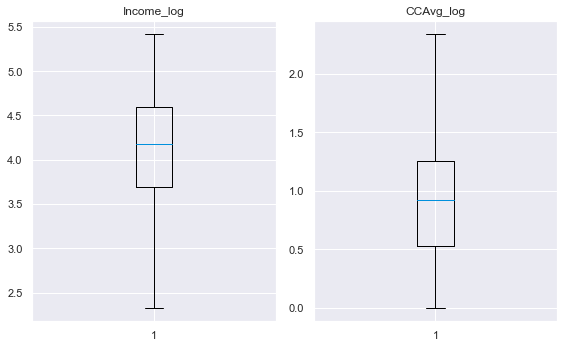

In [49]:
# lets look at box plot to see if outliers has been treated or not
plt.figure(figsize=(8,5))

for i, variable in enumerate(outlier_col):
                     plt.subplot(1,2,i+1)
                     plt.boxplot(df_customers2[variable],whis=1.5)
                     plt.tight_layout()
                     plt.title(variable)

plt.show()

## Data Preparation

In [50]:
# Defining X and Y variables
X = df_customers2.drop(["Personal_Loan"], axis=1)
y = df_customers2["Personal_Loan"]

#Splitting data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state = 1)

<font color=blue>

## Model building - Logistic Regression

### Model evaluation criterion:

#### Model can make wrong predictions as:
1. Predicting a customer would accept personal loan but actually wouldn't accept;
2. Predicting a customer wouldn't accept personal loan but actually would accept.

#### Which case is more important? 
- Predicting a customer wouldn't accept personal loan but actually would accept, i.e. False nagative

#### How to reduce this loss i.e need to reduce False Negatives?
- Company wants Recall to be maximized, greater the recall lesser the chances of false negatives

#### First, let's create two functions to calculate different metrics and confusion matrix, so that we don't have to use the same code repeatedly for each model.

In [51]:
##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision
def get_metrics_score(model,train,test,train_y,test_y,flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    
    score_list=[] 
    
    pred_train = model.predict(train)
    pred_test = model.predict(test)
    
    train_acc = accuracy_score(pred_train,train_y)
    test_acc = accuracy_score(pred_test,test_y)
    
    train_recall = recall_score(train_y,pred_train)
    test_recall = recall_score(test_y,pred_test)
    
    train_precision = precision_score(train_y,pred_train)
    test_precision = precision_score(test_y,pred_test)
    
    
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision))
        
     # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Accuracy on training set : ",accuracy_score(pred_train,train_y))
        print("Accuracy on test set : ",accuracy_score(pred_test,test_y))
        print("Recall on training set : ",recall_score(train_y,pred_train))
        print("Recall on test set : ",recall_score(test_y,pred_test))
        print("Precision on training set : ",precision_score(train_y,pred_train))
        print("Precision on test set : ",precision_score(test_y,pred_test))
    
    return score_list # returning the list with train and test scores

In [52]:
def make_confusion_matrix(model,test_X,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    y_predict = model.predict(test_X)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Before making the model, first let's **check if our variables has multicollinearity** with Variation Inflation Factor:

In [53]:
# dataframe with numerical column only
num_feature_set = X.copy()
num_feature_set = add_constant(num_feature_set)
num_feature_set = num_feature_set.astype(float)

In [54]:
vif_series1 = pd.Series([variance_inflation_factor(num_feature_set.values,i) for i in range(num_feature_set.shape[1])],index=num_feature_set.columns, dtype = float)
print('Series before feature selection: \n\n{}\n'.format(vif_series1))

Series before feature selection: 

const                         71.973384
Age_scaled                     1.009184
Income_log                     1.606018
Family                         1.022863
CCAvg_log                      1.557866
Education                      1.034406
Mortgage_log                   1.004336
Securities_Account             1.133927
CD_Account                     1.307222
Online                         1.040813
CreditCard                     1.107114
Region_Middle_California       1.285351
Region_Northern_California     1.287759
dtype: float64



- There's no multicollinearity present, we can rely on the model use it to make interpretations.

In [55]:
# build LogisticRegression model
model = LogisticRegression(random_state=1)
lg = model.fit(X_train,y_train)

Accuracy on training set :  0.9565714285714285
Accuracy on test set :  0.9526666666666667
Recall on training set :  0.6404833836858006
Recall on test set :  0.6174496644295302
Precision on training set :  0.8653061224489796
Precision on test set :  0.8679245283018868


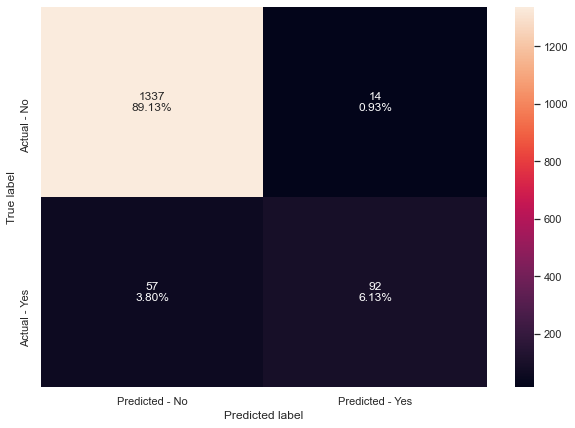

In [56]:
# checking model performance
scores_LR = get_metrics_score(lg,X_train,X_test,y_train,y_test,flag=True)

# creating confusion matrix
make_confusion_matrix(lg,X_test,y_test)

#### ROC-AUC:


ROC-AUC on training set:


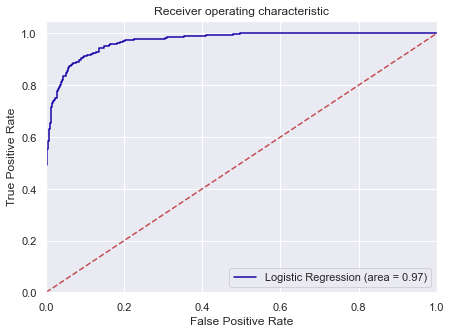

In [57]:
# ROC-AUC on training set
print("\nROC-AUC on training set:")
logit_roc_auc_train = roc_auc_score(y_train, lg.predict_proba(X_train)[:,1])
fpr, tpr, thresholds = roc_curve(y_train, lg.predict_proba(X_train)[:,1])
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc_train)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


ROC-AUC on test set:


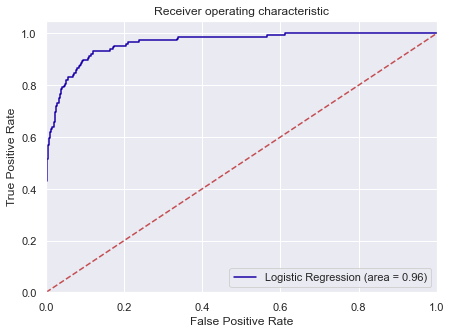

In [58]:
# ROC-AUC on test set
print("\nROC-AUC on test set:")
logit_roc_auc_test = roc_auc_score(y_test, lg.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, lg.predict_proba(X_test)[:,1])
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc_test)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

- Model has given a generalized performance on training and test set.
- Recall is less and we should try to improve it.
- Let's change the threshold to see if the model performance can be improved.

#### Finding the coefficients:

In [59]:
log_odds = lg.coef_[0]
pd.options.display.float_format = '{:.5f}'.format
pd.DataFrame(log_odds, X_train.columns, columns=['coef']).T

,Age_scaled,Income_log,Family,CCAvg_log,Education,Mortgage_log,Securities_Account,CD_Account,Online,CreditCard,Region_Middle_California,Region_Northern_California
coef,0.23927,5.87256,0.68503,0.86592,1.57364,0.04203,-0.84025,3.13295,-0.52440,-0.95535,-0.02469,0.03376


#### Coefficient interpretations:
- Coefficient of Age_scaled, Income_log, Family, CCAvg_log, Education, Mortgage_log, CD_Account, and Region_Northern_California are positive, **increase** in these will lead to **increase** in chances of a customer being the one who will accept personal loan. 
- Coefficient of Securities_Account, Online, CreditCard, and Region_Middle_California are negative, **increase** in these will lead to **decrease** in chances of a customer being the one who will accept personal loan.

#### Converting coefficients to odds: 
- The coefficients of the logistic regression model are in terms of log(odd), to find the odds we have to take the exponential of the coefficients. 
- When coefficient is b, **odds =  exp(b)**
- The percentage change in odds is given as **odds = (exp(b) - 1) * 100**
- Probability = odd/(1+odd)

In [60]:
# Odds from coefficients
print("\nOdds from coefficients:")
odds = np.exp(lg.coef_[0]) # converting coefficients to odds
pd.set_option('display.max_columns',None)  # removing limit from number of columns to display
pd.DataFrame(odds, X_train.columns, columns=['odds']).T # adding the odds to a dataframe


Odds from coefficients:


,Age_scaled,Income_log,Family,CCAvg_log,Education,Mortgage_log,Securities_Account,CD_Account,Online,CreditCard,Region_Middle_California,Region_Northern_California
odds,1.27032,355.15869,1.98384,2.37719,4.82417,1.04293,0.43160,22.94166,0.59191,0.38468,0.97562,1.03434


In [61]:
# Percentage change in odds
print("\nPercentage change in odds:")
perc_change_odds = (np.exp(lg.coef_[0])-1)*100 # finding the percentage change
pd.set_option('display.max_columns',None) # removing limit from number of columns to display
pd.DataFrame(perc_change_odds, X_train.columns, columns=['change_odds%']).T # adding the change_odds% to a dataframe


Percentage change in odds:


,Age_scaled,Income_log,Family,CCAvg_log,Education,Mortgage_log,Securities_Account,CD_Account,Online,CreditCard,Region_Middle_California,Region_Northern_California
change_odds%,27.03229,35415.86911,98.38390,137.71925,382.41735,4.29262,-56.83960,2194.16570,-40.80913,-61.53222,-2.43844,3.43373


#### Coefficient interpretations:

* `Age_scaled`: Holding all other features constant a 1 unit change in Age_scaled will increase the odds of a customer accepting personal loan by 1.2703 times or a 27.03% increase in odds of accepting personal loan.
* `Income_log`: Holding all other features constant a 1 unit change in Income_log will increase the odds of a customer accepting personal loan by 355.16 times or a 35415.87% increase in odds of accepting personal loan.
* `Securities_Account`: Holding all other features constant a 1 unit change in Securities_Account will decrease the odds of a customer accepting personal loan by 0.4316 times or a 56.83% decrease in odds of accepting personal loan.
* `CreditCard`: Holding all other features constant a 1 unit change in CreditCard will decrease the odds of a customer accepting personal loan by 0.3847 times or a 61.53% decrease in odds of accepting personal loan.
* The odds of a customer from middle region of California accepting personal loan is 0.9756 time less than the the customer from Southern California or 2.44% fewer odds of accepting personal loan. Similarly, The odds of a customer from Northern California ccepting personal loan is 1.0343 times more than the customer from Southern California or 3.43% more odds of accepting personal loan than the customer from Southern California. [keeping Southern_California category as a reference].

`Interpretation for other attributes can be done similarly.`

## Model Performance Improvement

#### Optimal threshold using AUC-ROC curve:

In [62]:
# Optimal threshold as per AUC-ROC curve
# The optimal cut off would be where tpr is high and fpr is low
fpr, tpr, thresholds = metrics.roc_curve(y_test, lg.predict_proba(X_test)[:,1])

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
# Model prediction with optimal threshold

pred_train_opt = (lg.predict_proba(X_train)[:,1]>optimal_threshold)
pred_test_opt = (lg.predict_proba(X_test)[:,1]>optimal_threshold)
print(optimal_threshold)

0.07875602592280999


In [63]:
# Model prediction with optimal threshold

pred_train_opt = (lg.predict_proba(X_train)[:,1]>optimal_threshold)
pred_test_opt = (lg.predict_proba(X_test)[:,1]>optimal_threshold)

train_acc = accuracy_score(y_train, pred_train_opt)
test_acc  = accuracy_score(y_test, pred_test_opt)

print('Accuracy on train data:',train_acc)
print('Accuracy on test data:',test_acc)

train_rec = recall_score(y_train, pred_train_opt)
test_rec  = recall_score(y_test, pred_test_opt)

print('Recall on train data:',train_rec)
print('Recall on test data:',test_rec)

train_prec = precision_score(y_train, pred_train_opt)
test_prec  = precision_score(y_test, pred_test_opt)

print('Precision on train data:',train_prec)
print('Precision on test data:',test_prec)

train_roc = roc_auc_score(y_train, pred_train_opt)
test_roc  = roc_auc_score(y_test, pred_test_opt)

print('ROC-AUC Score on train data:',train_roc)
print('ROC-AUC Score on test data:',test_roc)

scores_optimal = []
scores_optimal.extend((train_acc,test_acc,train_rec,test_rec,train_prec,test_prec))

Accuracy on train data: 0.876
Accuracy on test data: 0.884
Recall on train data: 0.9274924471299094
Recall on test data: 0.9261744966442953
Precision on train data: 0.4281729428172943
Precision on test data: 0.4584717607973422
ROC-AUC Score on train data: 0.8990570471686152
ROC-AUC Score on test data: 0.9027615636441313


- Model is giving a generalized performance on training and test set;
- There is a **significant improvement** in the model performance because **recall scores** of both training and test set have **increased** to 0.9275 and 0.9262 respectively.
- Area under the curve has decreased as compared to the initial model but the performance is generalized on training and test set.

#### Now Let's use Precision-Recall curve and see if we can find an even better threshold:

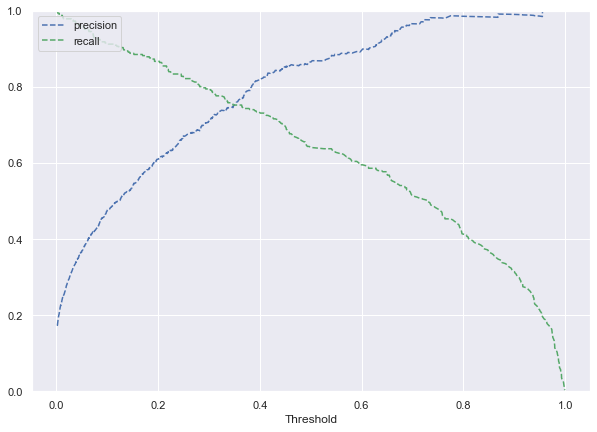

In [64]:
y_scores=lg.predict_proba(X_train)[:,1]
prec, rec, tre = precision_recall_curve(y_train, y_scores,)

def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])
plt.figure(figsize=(10,7))
plot_prec_recall_vs_tresh(prec, rec, tre)
plt.show()

- At threshold around 0.35 we will get equal precision and recall but taking a step back and selecting value around 0.3 will provide a higher recall and a good precision.

In [65]:
optimal_threshold = 0.3

# Model prediction with optimal threshold
pred_train_opt = (lg.predict_proba(X_train)[:,1]>optimal_threshold)
pred_test_opt = (lg.predict_proba(X_test)[:,1]>optimal_threshold)

#Model performance with optimal threhold

train_acc1 = accuracy_score(y_train, pred_train_opt)
test_acc1  = accuracy_score(y_test, pred_test_opt)

print('Accuracy on train data:',train_acc1)
print('Accuracy on test data:',test_acc1)

train_rec1 = recall_score(y_train, pred_train_opt)
test_rec1  = recall_score(y_test, pred_test_opt)

print('Recall on train data:',train_rec1)
print('Recall on test data:',test_rec1)

train_prec1 = precision_score(y_train, pred_train_opt)
test_prec1  = precision_score(y_test, pred_test_opt)

print('Precision on train data:',train_prec1)
print('Precision on test data:',test_prec1)

train_roc1 = roc_auc_score(y_train, pred_train_opt)
test_roc1  = roc_auc_score(y_test, pred_test_opt)

print('ROC-AUC Score on train data:',train_roc1)
print('ROC-AUC Score on test data:',test_roc1)

scores_prec_recall = []
scores_prec_recall.extend((train_acc1,test_acc1,train_rec1,test_rec1,train_prec1,test_prec1))

Accuracy on train data: 0.95
Accuracy on test data: 0.946
Recall on train data: 0.7945619335347432
Recall on test data: 0.7516778523489933
Precision on train data: 0.7108108108108108
Precision on test data: 0.717948717948718
ROC-AUC Score on train data: 0.8803986695127172
ROC-AUC Score on test data: 0.8595546922736824


- Model is performing well on training and test set.
- There's no improvement in the model performance.

## Sequential Feature Selector
- **Selecting subset of important features using Sequential Feature Selector method:**

In [66]:
# Sequential feature selector is present in mlxtend library
# !pip install mlxtend to install mlxtent library

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# to plot the performance with addition of each feature
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [67]:
## Defining X and Y variables
X = df_customers2.drop(["Personal_Loan"], axis=1)
y = df_customers2["Personal_Loan"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30,random_state=1)

In [68]:
# Fit the model on train
model = LogisticRegression(solver='newton-cg',n_jobs=-1,random_state=1,max_iter=100)

In [69]:
X_train.shape

(3500, 12)

In [70]:
# we will first build model with all varaible
sfs = SFS(model, k_features=12, forward=True, floating=False, scoring='recall', verbose=2, cv=3,n_jobs=-1)

sfs = sfs.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.9s finished

[2021-05-22 16:38:02] Features: 1/12 -- score: 0.30827190827190826[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.6s finished

[2021-05-22 16:38:03] Features: 2/12 -- score: 0.543980343980344[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.6s finished

[2021-05-22 16:38:03] Features: 3/12 -- score: 0.6013104013104013[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.5s finished

[2021-05-22 16:38:04] Features: 4/12 -- score: 0.61

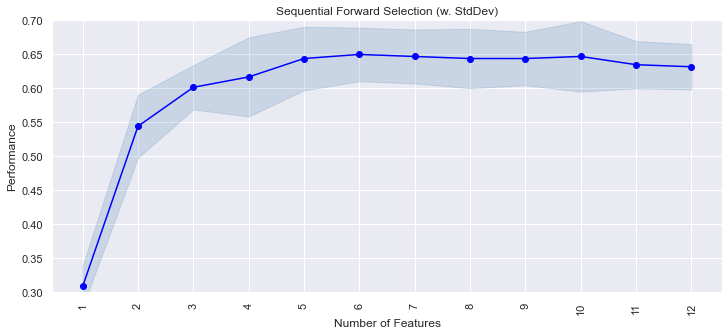

In [71]:
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev',figsize=(12,5))
plt.ylim([0.3, 0.7])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.xticks(rotation=90)
plt.show()

- We can see that Adjusted-R square starts decreasing after addition of 6th feature, so we will proceed only with best 5 features;
- Now we'll change k_features to 6.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.3s finished

[2021-05-22 16:38:07] Features: 1/6 -- score: 0.30827190827190826[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.5s finished

[2021-05-22 16:38:07] Features: 2/6 -- score: 0.543980343980344[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s finished

[2021-05-22 16:38:08] Features: 3/6 -- score: 0.6013104013104013[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.5s finished

[2021-05-22 16:38:09] Features: 4/6 -- score: 0.616543

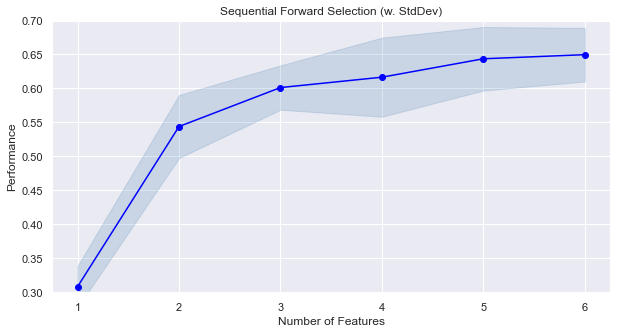

In [72]:
sfs1 = SFS(model, k_features=6, forward=True, floating=False, scoring='recall', verbose=2, cv=3,n_jobs=-1)

sfs1 = sfs1.fit(X_train, y_train)

fig1 = plot_sfs(sfs1.get_metric_dict(),kind='std_dev',figsize=(10,5))

plt.ylim([0.3, 0.7])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.show()

In [73]:
# Finding which features are important
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)

[0, 1, 2, 4, 7, 9]


In [74]:
# Let's look at best 6 variables
X_train.columns[feat_cols]

Index(['Age_scaled', 'Income_log', 'Family', 'Education', 'CD_Account',
       'CreditCard'],
      dtype='object')

In [75]:
X_train_final = X_train[X_train.columns[feat_cols]]

#Creating new x_test with the same variables that we selected for x_train
X_test_final = X_test[X_train_final.columns]

In [76]:
#Fitting logistic regession model

logreg = LogisticRegression(solver='newton-cg',max_iter=1000,penalty='none',verbose=True,n_jobs=-1,random_state=0)

# There are several optimizer, we are using optimizer called as 'newton-cg' with max_iter equal to 10000 
# max_iter indicates number of iteration needed to converge

logreg.fit(X_train_final, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


LogisticRegression(max_iter=1000, n_jobs=-1, penalty='none', random_state=0,
                   solver='newton-cg', verbose=True)

#### Let's Look at model performance:

Accuracy on training set :  0.9574285714285714
Accuracy on test set :  0.9513333333333334
Recall on training set :  0.6676737160120846
Recall on test set :  0.6174496644295302
Precision on training set :  0.85
Precision on test set :  0.8518518518518519


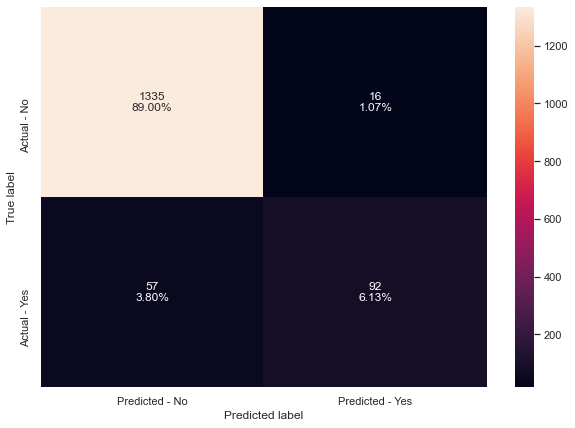

In [77]:
scores_LR = get_metrics_score(logreg,X_train_final,X_test_final,y_train,y_test,flag=True)

# creating confusion matrix
make_confusion_matrix(logreg,X_test_final,y_test)

- Model is giving a generalized performance on training and test set.
- With a fewer number of features, the model performance is comparable to the initial logistic regression model.

### Model Performance Summary:

In [78]:
# defining list of model
models = [lg]

# defining empty lists to add train and test results
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []


# looping through the models list to get the metrics score - Accuracy, Recall, and Precision
for model in models:
    
    j = get_metrics_score(model,X_train,X_test,y_train,y_test,False)
    acc_train.append(j[0])
    acc_test.append(j[1])
    recall_train.append(j[2])
    recall_test.append(j[3])
    precision_train.append(j[4])
    precision_test.append(j[5])

In [79]:
# defining list of model
models = [logreg]

# looping through all the models list to get the metrics score - Accuracy, Recall, Precision, and F1 score
for model in models:
    
    j = get_metrics_score(model,X_train_final,X_test_final,y_train,y_test,False)
    acc_train.append(j[0])
    acc_test.append(j[1])
    recall_train.append(j[2])
    recall_test.append(j[3])
    precision_train.append(j[4])
    precision_test.append(j[5])

In [80]:
# getting the scores of model with optimal threshold of 0.58 to get the metrics score - Accuracy, Recall, Precision, and F1 score
acc_train.append(scores_optimal[0])
acc_test.append(scores_optimal[1])
recall_train.append(scores_optimal[2])
recall_test.append(scores_optimal[3])
precision_train.append(scores_optimal[4])
precision_test.append(scores_optimal[5])

# getting the scores of model with optimal threshold of 0.71 to get the metrics score - Accuracy, Recall, Precision, and F1 score
acc_train.append(scores_prec_recall[0])
acc_test.append(scores_prec_recall[1])
recall_train.append(scores_prec_recall[2])
recall_test.append(scores_prec_recall[3])
precision_train.append(scores_prec_recall[4])
precision_test.append(scores_prec_recall[5])

In [81]:
comparison_frame = pd.DataFrame({'Model':['Initial Logistic Regression Model with sklearn',
                                          'SFS - Logitic Regression Model (6 variables)',
                                          'Logistic Regression - Optimal threshold = 0.079',
                                          'Logistic Regression - Optimal threshold = 0.3'],
                                          'Train_Accuracy':acc_train, 
                                          'Test_Accuracy':acc_test,
                                          'Train Recall':recall_train,
                                          'Test Recall':recall_test, 
                                          'Train Precision':precision_train,
                                          'Test Precision':precision_test
                                })
                                    

comparison_frame

,Model,Train_Accuracy,Test_Accuracy,Train Recall,Test Recall,Train Precision,Test Precision
0,Initial Logistic Regression Model with sklearn,0.95657,0.95267,0.64048,0.61745,0.86531,0.86792
1,SFS - Logitic Regression Model (6 variables),0.95743,0.95133,0.66767,0.61745,0.85000,0.85185
2,Logistic Regression - Optimal threshold = 0.079,0.87600,0.88400,0.92749,0.92617,0.42817,0.45847
3,Logistic Regression - Optimal threshold = 0.3,0.95000,0.94600,0.79456,0.75168,0.71081,0.71795


<font color=blue>

## Model building - Decision Tree

In [82]:
# We are using non-scaled dataset 
# Defining X and Y variables
X = df_customers.drop(["Personal_Loan"], axis=1)
y = df_customers["Personal_Loan"]

#Splitting data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state = 1)

- We will build our model using the DecisionTreeClassifier function. Using default 'gini' criteria to split;
- From earlier analysis we are aware that the dataset is imbalance because only 9.60% of customers are those who accepted personal loan.

In [83]:
df_customers["Personal_Loan"].value_counts(normalize=True)

0   0.90400
1   0.09600
Name: Personal_Loan, dtype: float64

- To prevent Decision Tree from becoming biased in predictions, we will pass a dictionary {0:0.096,1:0.904} to the model to specify the weight of each class and the decision tree will give more weightage to class 1.

In [84]:
model2 = DecisionTreeClassifier(criterion='gini',class_weight={0:0.096,1:0.904},random_state=1)
model2.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.096, 1: 0.904}, random_state=1)

#### Scoring our Decision Tree:

In [85]:
# accuracy on training set
print("Accuracy on train set", model2.score(X_train,y_train))

# accuracy on test set
print("Accuracy on test set", model2.score(X_test,y_test))

Accuracy on train set 1.0
Accuracy on test set 0.985


In [86]:
def make_confusion_matrix_DTree(model,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    y_predict = model.predict(X_test)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

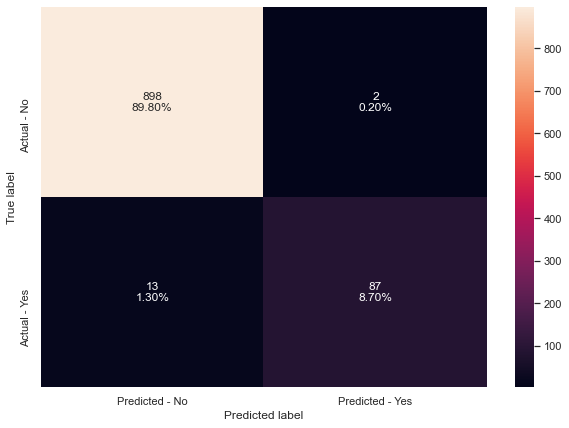

In [87]:
make_confusion_matrix_DTree(model2,y_test)

In [88]:
y_train.value_counts(1)

0   0.90500
1   0.09500
Name: Personal_Loan, dtype: float64

- We only have 9.6% of positive classes, so if our model marks each sample as negative, then also we'll get 90.4% accuracy, hence accuracy is not a good metric to evaluate here;
- Also, from earlier analysis we have confirmed that recall is the right metric to check the performance of the model we are building.

In [89]:
##  Function to calculate recall score
def get_recall_score(model):
    '''
    model : classifier to predict values of X

    '''
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print("Recall on training set : ",metrics.recall_score(y_train,pred_train))
    print("Recall on test set : ",metrics.recall_score(y_test,pred_test))

In [90]:
get_recall_score(model2)

Recall on training set :  1.0
Recall on test set :  0.87


- Recall on training and test set is very good.

### Visualizing the Decision Tree

In [91]:
feature_names = list(X.columns)
print(feature_names)

['Age', 'Income', 'Family', 'CCAvg', 'Education', 'Mortgage', 'Securities_Account', 'CD_Account', 'Online', 'CreditCard', 'Region_Middle_California', 'Region_Northern_California']


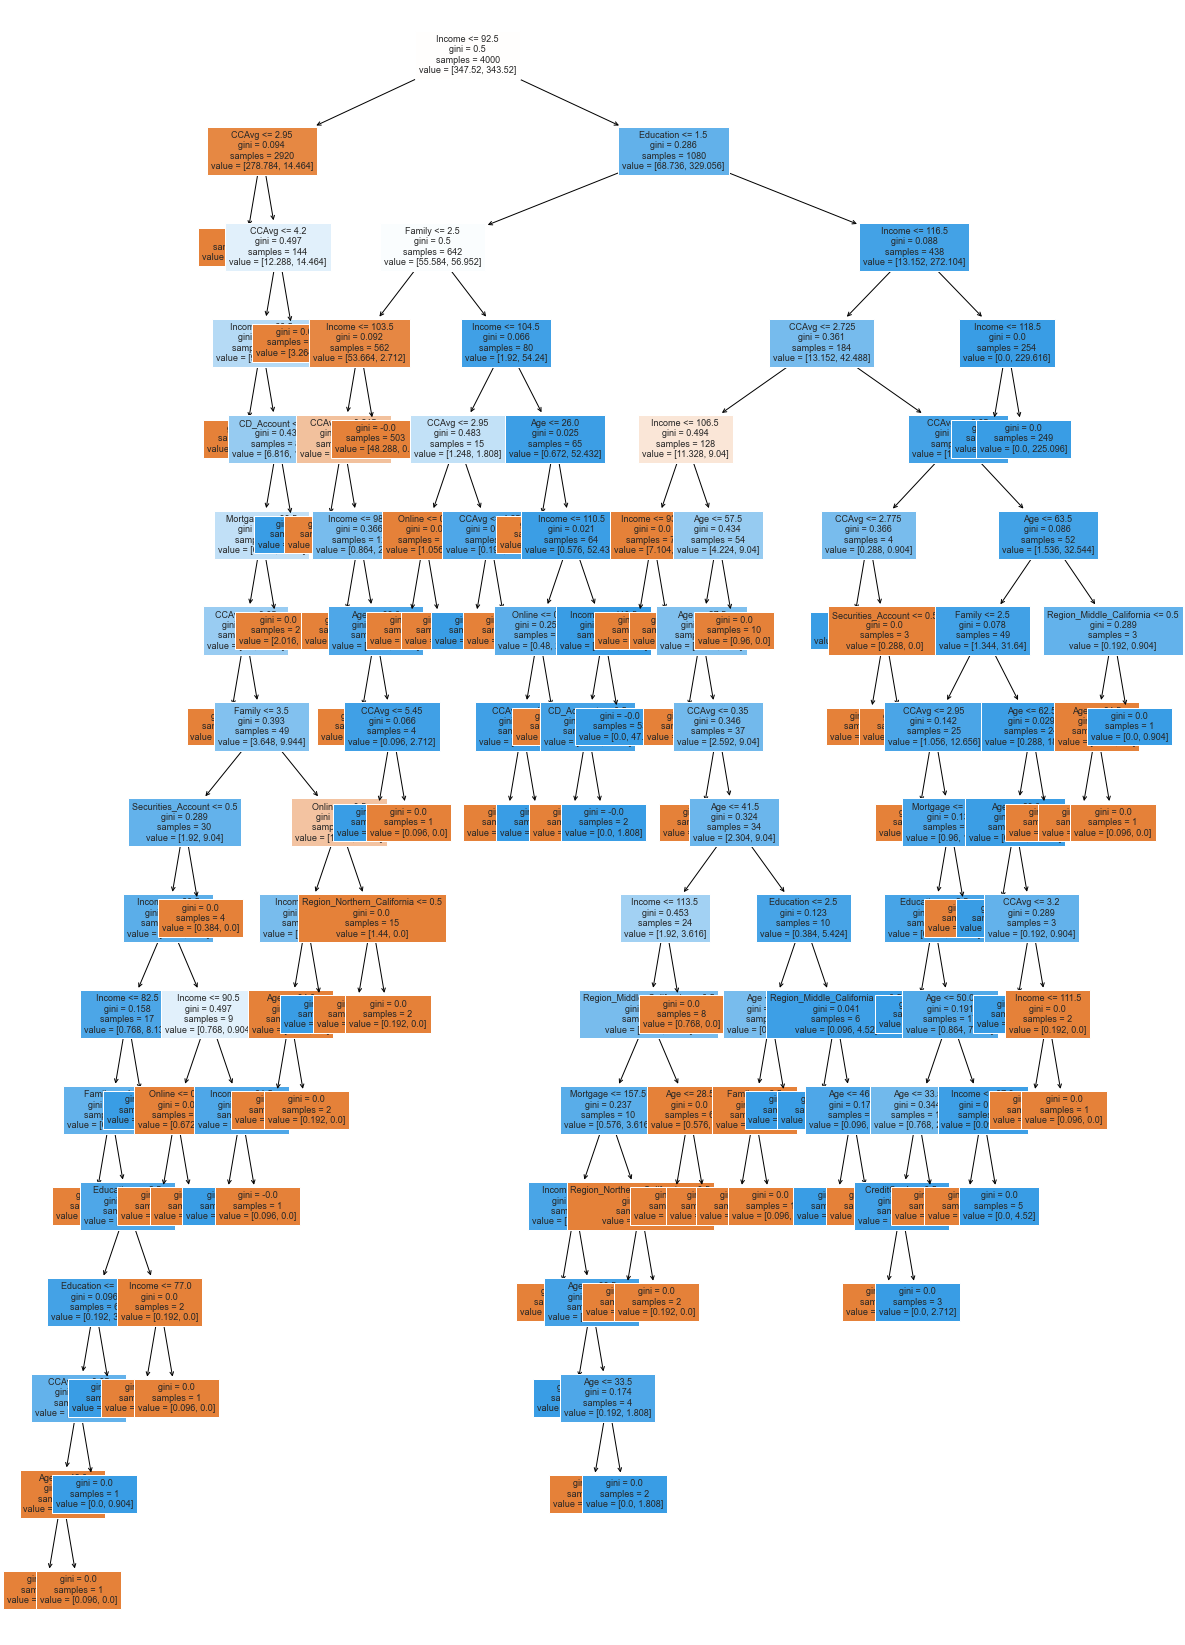

In [92]:
plt.figure(figsize=(20,30))
out = tree.plot_tree(model2,feature_names=feature_names,filled=True,fontsize=9,node_ids=False,class_names=None,)
#below code will add arrows to the decision tree split if they are missing
for o in out:
     arrow = o.arrow_patch
     if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(1)
plt.show()

In [93]:
# Text report showing the rules of a decision tree -

print(tree.export_text(model2,feature_names=feature_names,show_weights=True))

|--- Income <= 92.50
|   |--- CCAvg <= 2.95
|   |   |--- weights: [266.50, 0.00] class: 0
|   |--- CCAvg >  2.95
|   |   |--- CCAvg <= 4.20
|   |   |   |--- Income <= 68.50
|   |   |   |   |--- weights: [2.21, 0.00] class: 0
|   |   |   |--- Income >  68.50
|   |   |   |   |--- CD_Account <= 0.50
|   |   |   |   |   |--- Mortgage <= 99.50
|   |   |   |   |   |   |--- CCAvg <= 3.05
|   |   |   |   |   |   |   |--- weights: [1.15, 0.00] class: 0
|   |   |   |   |   |   |--- CCAvg >  3.05
|   |   |   |   |   |   |   |--- Family <= 3.50
|   |   |   |   |   |   |   |   |--- Securities_Account <= 0.50
|   |   |   |   |   |   |   |   |   |--- Income <= 83.50
|   |   |   |   |   |   |   |   |   |   |--- Income <= 82.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 6
|   |   |   |   |   |   |   |   |   |   |--- Income >  82.50
|   |   |   |   |   |   |   |   |   |   |   |--- weights: [0.00, 4.52] class: 1
|   |   |   |   |   |   |   |   |   |--- Income >  83.50
|   

In [94]:
# importance of features in the tree building (The importance of a feature is computed as the 
#(normalized) total reduction of the 'criterion' brought by that feature. 
#It is also known as the Gini importance)
print (pd.DataFrame(model2.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

                               Imp
Income                     0.64180
Family                     0.14184
Education                  0.09525
CCAvg                      0.08659
Age                        0.01485
Mortgage                   0.00649
Online                     0.00400
CD_Account                 0.00394
Region_Middle_California   0.00314
Securities_Account         0.00157
CreditCard                 0.00054
Region_Northern_California 0.00000


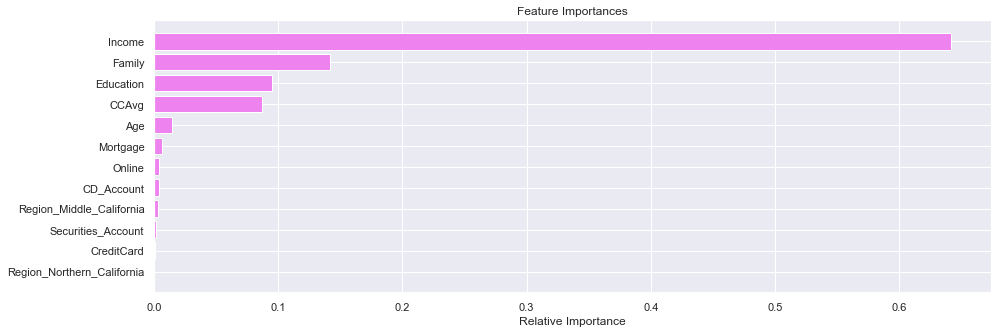

In [95]:
importances = model2.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(15,5))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

- According to the decision tree model, Income is the most important variable for predicting whether a customer would accept personal loan offered  by AllLife Bank.

### Reducing over fitting
- Using GridSearch for Hyperparameter tuning of our tree model

In [96]:
# Choose the type of classifier. 
estimator = DecisionTreeClassifier(random_state=1,class_weight = {0:0.096,1:0.904})

# Grid of parameters to choose from
parameters = {
            'max_depth': np.arange(1,10),
            'criterion': ['entropy','gini'],
            'splitter': ['best','random'],
            'min_impurity_decrease': [0.000001,0.00001,0.0001],
            'max_features': ['log2','sqrt']
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(estimator, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
estimator.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.096, 1: 0.904}, criterion='entropy',
                       max_depth=2, max_features='log2',
                       min_impurity_decrease=1e-06, random_state=1)

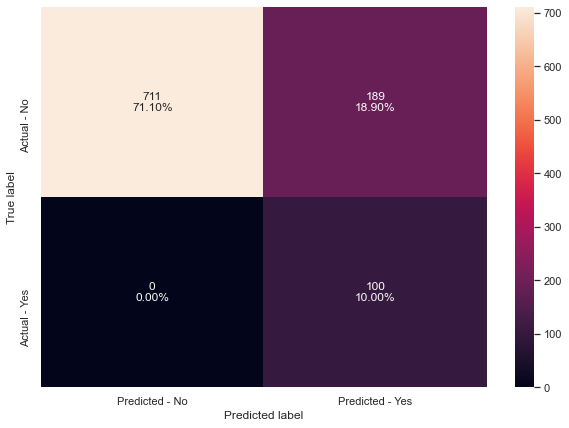

In [97]:
make_confusion_matrix_DTree(estimator,y_test)

- We can see that our model has performed very badly even thoug we would be getting high recall but our model is not able to distinguish between loan delinquent and non delinquent customers.

In [98]:
get_recall_score(estimator)

Recall on training set :  1.0
Recall on test set :  1.0


#### Visualizing the Decision Tree:

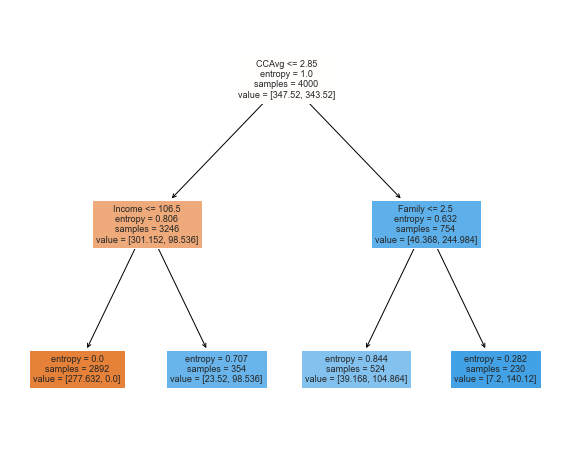

In [99]:
plt.figure(figsize=(10,8))
out = tree.plot_tree(estimator,feature_names=feature_names,filled=True,fontsize=9,node_ids=False,class_names=None)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(1)
plt.show()

-  Hyperparameter tuning didn't help our model.

#### Cost Complexity Pruning:

In [100]:
clf = DecisionTreeClassifier(random_state=1,class_weight = {0:0.096,1:0.904})
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [101]:
pd.DataFrame(path).head()

,ccp_alphas,impurities
0,0.00000,-0.00000
1,0.00000,-0.00000
2,0.00000,-0.00000
3,0.00000,-0.00000
4,0.00000,-0.00000


In [102]:
pd.DataFrame(path).tail()

,ccp_alphas,impurities
49,0.00622,0.05162
50,0.00838,0.06838
51,0.02057,0.08894
52,0.05771,0.20436
53,0.29563,0.49998


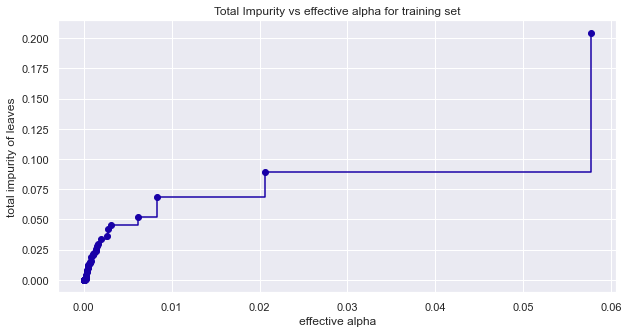

In [103]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

Next, we train a decision tree using the effective alphas. The last value in ccp_alphas is the alpha value that prunes the whole tree, leaving the tree, clfs[-1], with one node.

In [104]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=1, ccp_alpha=ccp_alpha,class_weight = {0:0.096,1:0.904})
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.2956262502736654


For the remainder, we remove the last element in clfs and ccp_alphas, because it is the trivial tree with only one node. Here we show that the number of nodes and tree depth decreases as alpha increases.

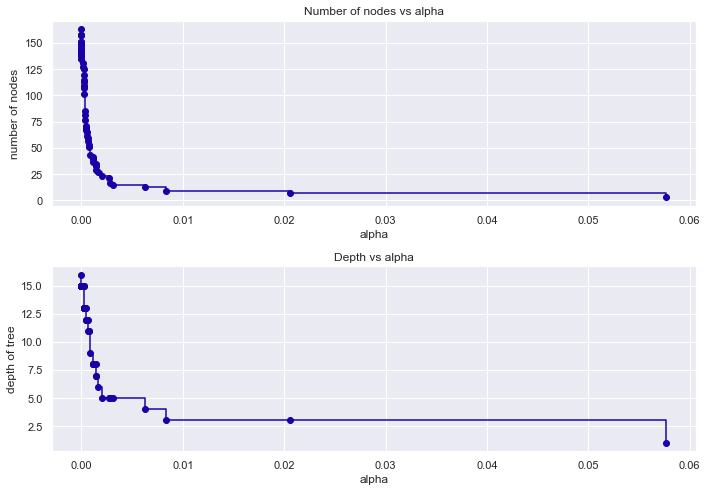

In [105]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1,figsize=(10,7))
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

In [106]:
recall_train=[]
for clf in clfs:
    pred_train3=clf.predict(X_train)
    values_train=metrics.recall_score(y_train,pred_train3)
    recall_train.append(values_train)

In [107]:
recall_test=[]
for clf in clfs:
    pred_test3=clf.predict(X_test)
    values_test=metrics.recall_score(y_test,pred_test3)
    recall_test.append(values_test)

In [108]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

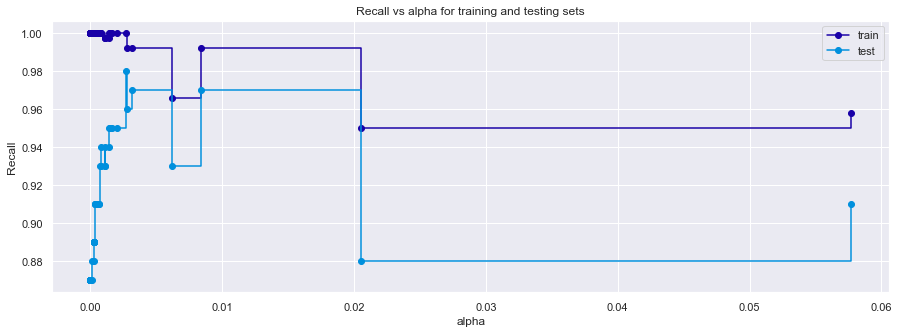

In [109]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_xlabel("alpha")
ax.set_ylabel("Recall")
ax.set_title("Recall vs alpha for training and testing sets")
ax.plot(ccp_alphas, recall_train, marker='o', label="train",
        drawstyle="steps-post",)
ax.plot(ccp_alphas, recall_test, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

**Maximum value of Recall is at 0.003 alpha, which is good, as it is retaining most information while getting higher recall.**

In [110]:
# creating the model where we get highest train and test recall
index_best_model = np.argmax(recall_test)
best_model = clfs[index_best_model]
print(best_model)

DecisionTreeClassifier(ccp_alpha=0.0026747613706593516,
                       class_weight={0: 0.096, 1: 0.904}, random_state=1)


In [111]:
best_model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0026747613706593516,
                       class_weight={0: 0.096, 1: 0.904}, random_state=1)

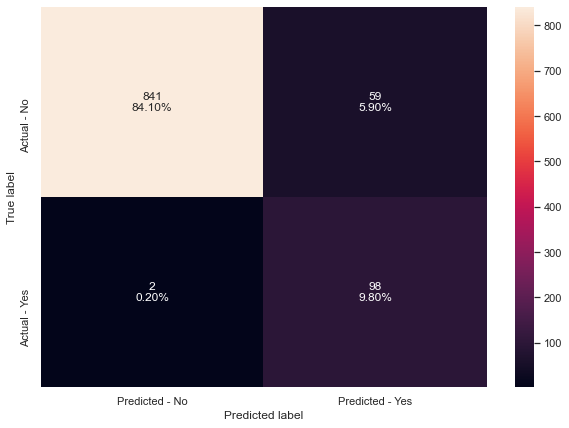

In [112]:
make_confusion_matrix_DTree(best_model,y_test)

In [113]:
get_recall_score(best_model)

Recall on training set :  1.0
Recall on test set :  0.98


#### Visualizing the Decision Tree:

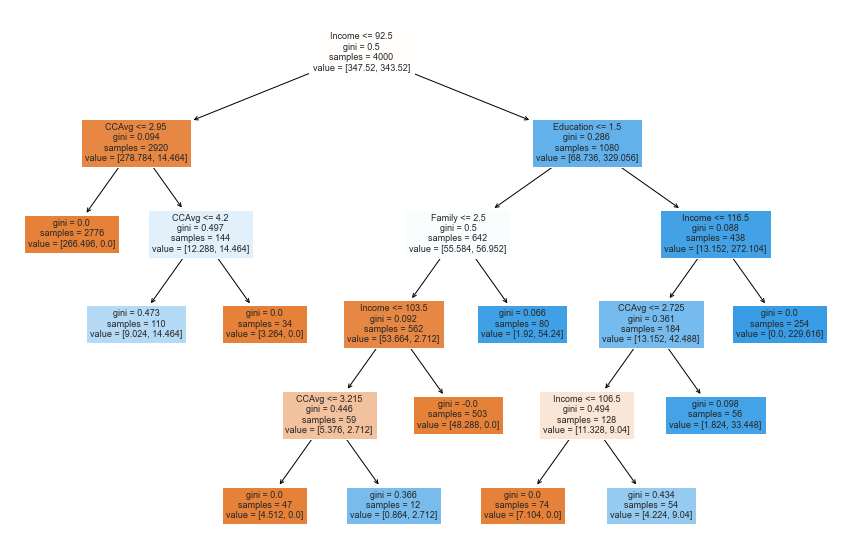

In [114]:
plt.figure(figsize=(15,10))

out = tree.plot_tree(best_model,feature_names=feature_names,filled=True,fontsize=9,node_ids=False,class_names=None)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(1)
plt.show()

In [115]:
# Text report showing the rules of a decision tree -

print(tree.export_text(best_model,feature_names=feature_names,show_weights=True))

|--- Income <= 92.50
|   |--- CCAvg <= 2.95
|   |   |--- weights: [266.50, 0.00] class: 0
|   |--- CCAvg >  2.95
|   |   |--- CCAvg <= 4.20
|   |   |   |--- weights: [9.02, 14.46] class: 1
|   |   |--- CCAvg >  4.20
|   |   |   |--- weights: [3.26, 0.00] class: 0
|--- Income >  92.50
|   |--- Education <= 1.50
|   |   |--- Family <= 2.50
|   |   |   |--- Income <= 103.50
|   |   |   |   |--- CCAvg <= 3.21
|   |   |   |   |   |--- weights: [4.51, 0.00] class: 0
|   |   |   |   |--- CCAvg >  3.21
|   |   |   |   |   |--- weights: [0.86, 2.71] class: 1
|   |   |   |--- Income >  103.50
|   |   |   |   |--- weights: [48.29, 0.00] class: 0
|   |   |--- Family >  2.50
|   |   |   |--- weights: [1.92, 54.24] class: 1
|   |--- Education >  1.50
|   |   |--- Income <= 116.50
|   |   |   |--- CCAvg <= 2.73
|   |   |   |   |--- Income <= 106.50
|   |   |   |   |   |--- weights: [7.10, 0.00] class: 0
|   |   |   |   |--- Income >  106.50
|   |   |   |   |   |--- weights: [4.22, 9.04] class: 1
|   

In [116]:
# importance of features in the tree building 
print (pd.DataFrame(best_model.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

                               Imp
Income                     0.67201
Family                     0.14801
Education                  0.10110
CCAvg                      0.07888
Age                        0.00000
Mortgage                   0.00000
Securities_Account         0.00000
CD_Account                 0.00000
Online                     0.00000
CreditCard                 0.00000
Region_Middle_California   0.00000
Region_Northern_California 0.00000


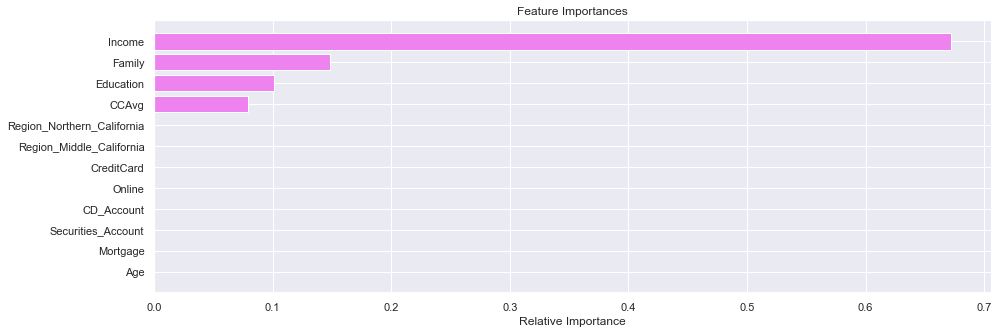

In [117]:
importances = best_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(15,5))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

- Income remains as the most important feature to predict whether a customer would accept a personal loan, followed by Family and then Education and CCAvg.

In [118]:
comparison_frame = pd.DataFrame({'Model':['Initial decision tree model','Decision treee with hyperparameter tuning',
                                          'Decision tree with post-pruning'], 'Train_Recall':[1,1,1], 'Test_Recall':[0.87,1,0.99]}) 
comparison_frame

,Model,Train_Recall,Test_Recall
0,Initial decision tree model,1,0.87000
1,Decision treee with hyperparameter tuning,1,1.00000
2,Decision tree with post-pruning,1,0.99000


**Decision tree with post-pruning is giving the highest recall on the test set, even though we got recall as 1 with hyperparameter tuning but that model wasn't a generalized one**

## Actionable Insights & Recommendations

<font color=darkblue>

- We used Logistic Regression and Decision Tree Classifier to build a predictive models for predicting if a customer is going to accept the personal loan offered by AllLife bank or not.
- Less data preparation is needed for Decision Trees and such a simple model gave good results even with outliers and imbalanced classes which shows the robustness of Decision Trees.
- Nonetheless, it turns out that Logistic Regression model is giving a more generalized performance on training and test set than Decision Tree Classifier does.
- Both models preedicted that 'Income', 'Family', and 'Education' are among the most significant variables, of which 'Income' is the most crucial one.
- Logistic Regression model however also predicted that 'Age_scaled', 'CD_Account', and 'CreditCard' are important variables.
- In contrast, Decision Tree Classifier predicted that 'CCAvg' is also an important variable.
- Overall, we should target more customers with higher income because they are most likely to accept a personal loan.
- Within those customers with high income, we should perhaps also check whether they have a certificate of deposit (CD) account with the bank. Because from our EDA we found out that nearly half of those who accepted personal loan also have a CD account with the bank, even though this variable wasn't captured by Decision Tree Classifier as important variable.

## Exploratory Data Analysis on the incorrectly predicted data

### 1) Logistic Regression model:

In [119]:
# Defining X and Y variables
X_lg = df_customers2.drop(["Personal_Loan"], axis=1)
y_lg = df_customers2["Personal_Loan"]

In [120]:
# find the ncorrectly predicted or misclassified samples
optimal_threshold = 0.078756
pred_y_lg = (lg.predict_proba(X_lg)[:,1]>optimal_threshold)

# we will do EDA on the samples before scaling was applied
misclassfied_lg = df_customers[pred_y_lg != y_lg]
misclassfied_lg.head()

,Age,Income,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,Region_Middle_California,Region_Northern_California
10,65,105,4,2.40000,3,0,0,0,0,0,0,0,1
12,48,114,2,3.80000,3,0,0,1,0,0,0,1,0
24,36,152,2,3.90000,1,159,0,0,0,0,1,0,1
26,40,83,4,0.20000,3,0,0,0,0,0,0,0,1
39,38,80,4,0.70000,3,285,0,0,0,1,0,1,0


In [121]:
misclassfied_lg.shape

(607, 13)

In [122]:
misclassfied_lg[con_col].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,607.00000,44.44975,11.60675,23.00000,35.00000,44.00000,54.00000,67.00000
Income,607.00000,124.07743,41.09004,53.00000,85.00000,113.00000,158.50000,224.00000
CCAvg,607.00000,3.52290,2.30665,0.00000,1.80000,2.80000,4.60000,8.80000
Mortgage,607.00000,77.98847,136.97409,0.00000,0.00000,0.00000,132.00000,635.00000


- Notice that the mean and median income values from misclassified samples are nearly double of the corresponding mean and median from the original dataset.

### Let's perform EDA on those variables being marked as important by Logistic Regression:

### Univariate analysis

#### Observations on Income:

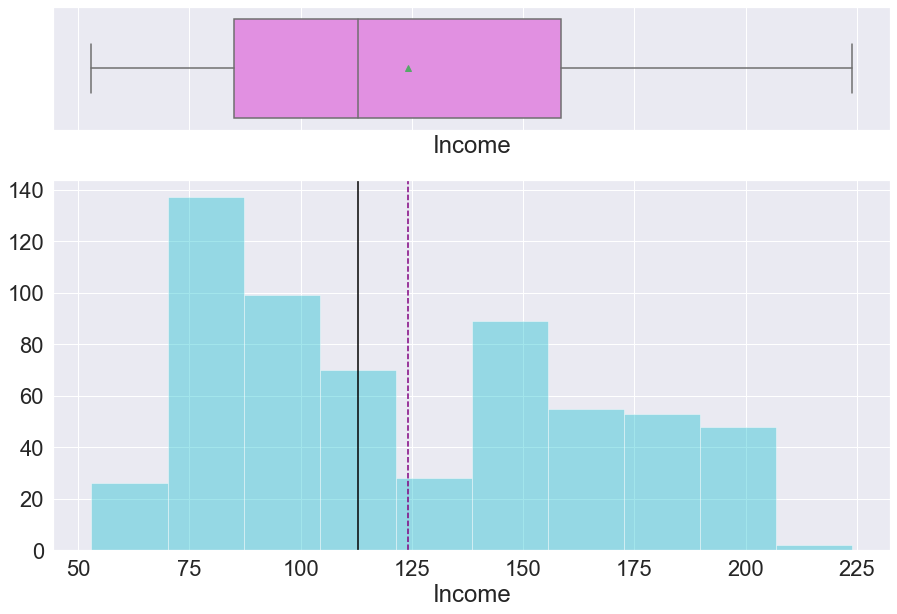

In [123]:
histogram_boxplot(misclassfied_lg["Income"])

- Note that this misclassified samples haven't been treated for its outlier, but we there aren't any outliers observed in the boxplot above.
- The distribution is somewhat right-skewed.
- Its mean income is about 125,000, higher than the mean observed in the original dataset, which was only 73,000.

#### Observations on Age:

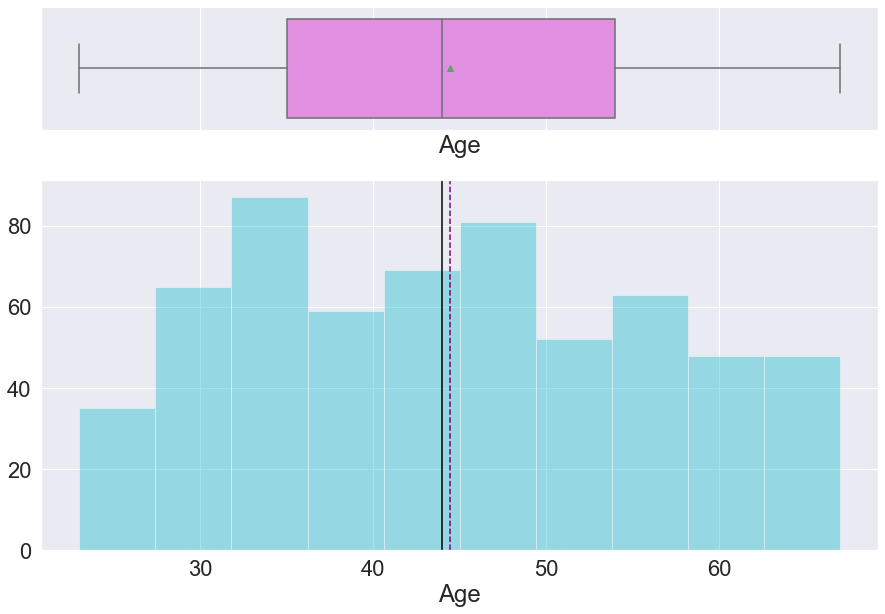

In [124]:
histogram_boxplot(misclassfied_lg["Age"])

- There isn't much difference as compared with the observation on the original dataset.

#### Observations on the family size of customers:

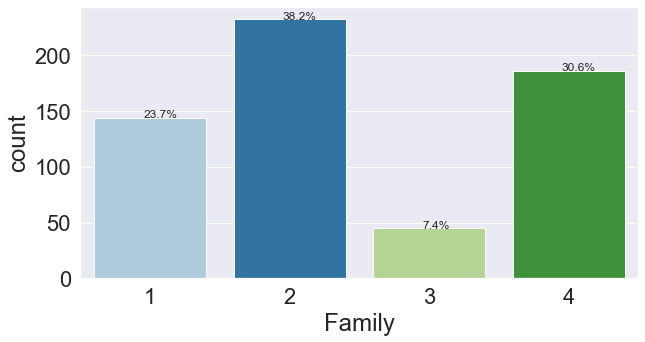

In [125]:
perc_on_bar(misclassfied_lg["Family"])

- Within misclassified samples there are more customers with family size of 2 than customers with family size of 1, the opposite of what we observed from original dataset.

#### Observations on education level of customers:

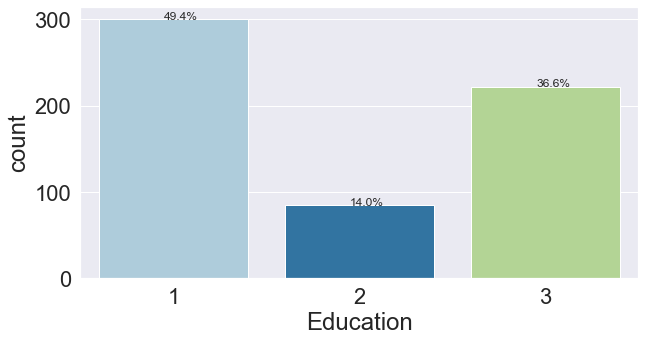

In [126]:
perc_on_bar(misclassfied_lg["Education"])

- Interestingly, there is only 14% of misclassfied samples are graduates, which is half of the percentage in original dataset.

#### Observations on whether the customer has a certificate of deposit (CD) account with the bank:

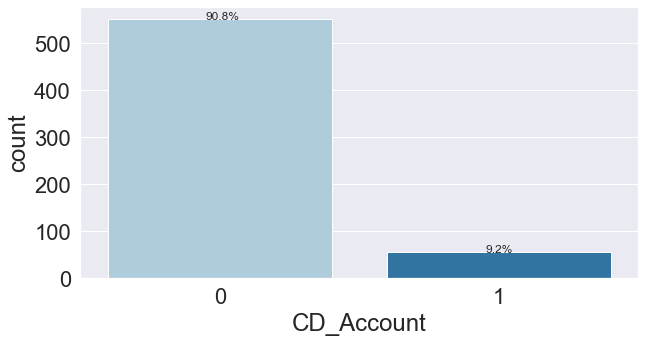

In [127]:
perc_on_bar(misclassfied_lg["CD_Account"])

- There are 9.2% of misclassfied samples have a certificate of deposit (CD) account with the bank, higher percentage than the original dataset, which was only 6%.

#### Observations on whether the customer use a credit card issued by any other Bank:

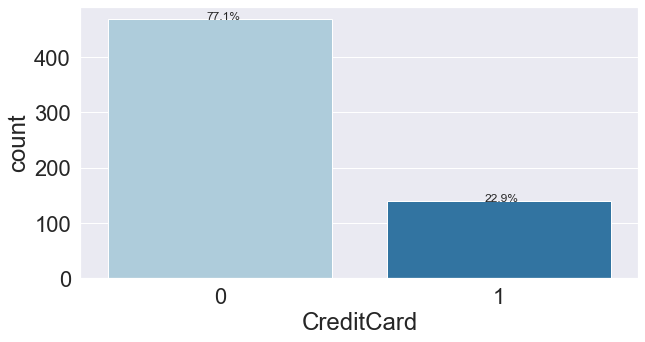

In [128]:
perc_on_bar(misclassfied_lg["CreditCard"])

- There are 22.9% of misclassfied samples use a credit card issued by any other Bank, as compared with 29.4% from the original dataset.

### Bivariate Analysis

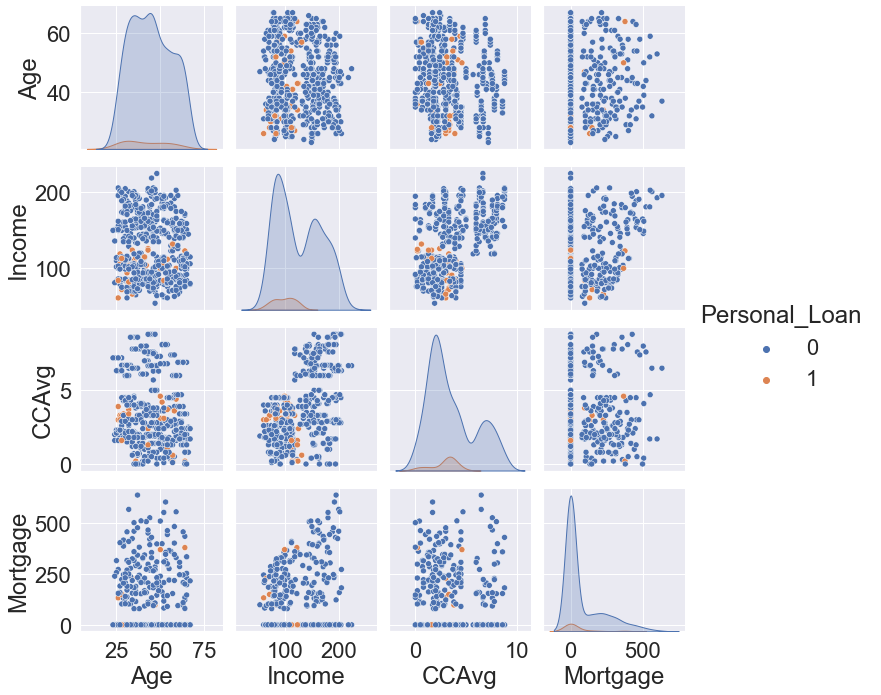

In [129]:
# check the linear relationships of numerical variables
con_col.append("Personal_Loan") #add "Personal_Loan" into continous column list to plot with  hue parameter
sns.pairplot(misclassfied_lg[con_col],hue="Personal_Loan");

- There isn't any appareent pattern observed in pairplot.

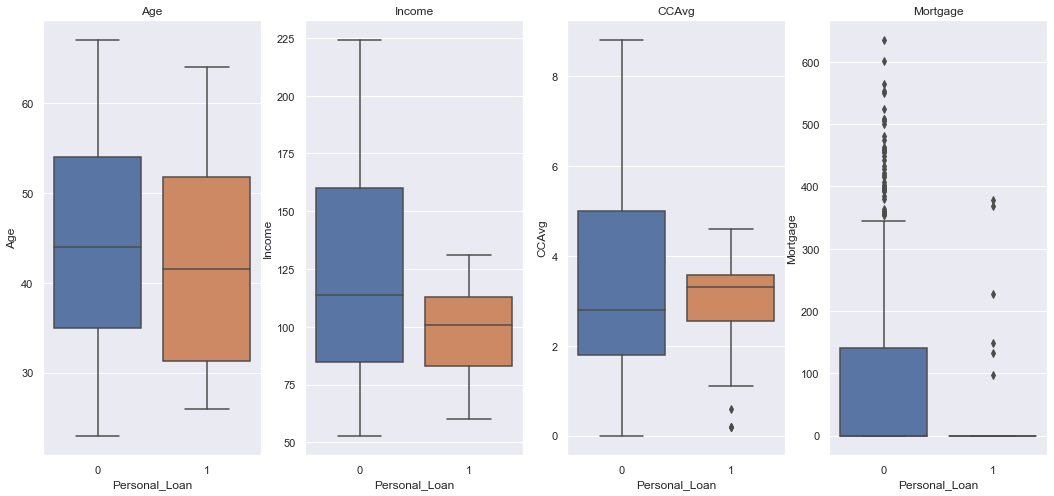

In [130]:
con_col.remove("Personal_Loan")
sns.set(rc={"figure.figsize": (18, 8)})
for i, variable in enumerate(con_col):
    plt.subplot(1,len(con_col),i+1)    
    sns.boxplot(x="Personal_Loan", y=variable, data=misclassfied_lg, orient="vertical")
    plt.title(variable)                   
plt.show()

- misclassfied samples have a very diversed distributions with respect to target variable, as compared with the original dataset.

#### Personal_Loan vs Family:

Personal_Loan    0   1  All
Family                     
1              130  14  144
2              225   7  232
3               37   8   45
4              181   5  186
All            573  34  607
--------------------------------------------------------------------------------------------------------------


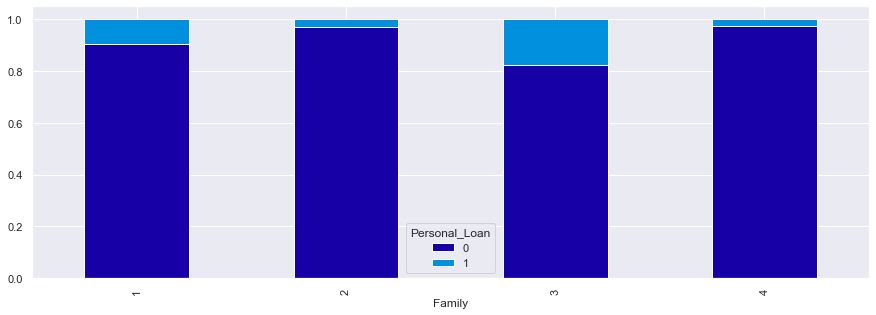

In [131]:
stacked_plot(misclassfied_lg["Family"])

- The percentage of customers from family size 1 in misclassified samples who actually accepted personal loan is about the same as the one in original dataset; while customers with family size of 3 have a slightly larger proportion than the same group from original dataset.
- However there are significantly less proportion of customers with family size of 2 & 4 in misclassfied samples who actually accepted personal loan as compared with the original dataset.

#### Personal_Loan vs Education:

Personal_Loan    0   1  All
Education                  
1              280  20  300
2               71  14   85
3              222   0  222
All            573  34  607
--------------------------------------------------------------------------------------------------------------


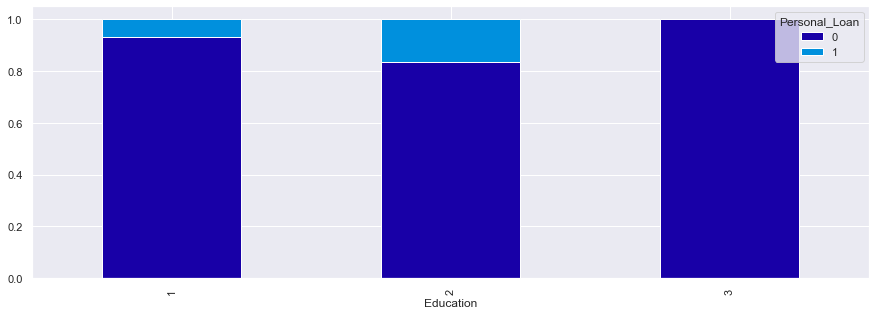

In [132]:
stacked_plot(misclassfied_lg["Education"])

- There isn't any advanced/proferssional who actually accepted personal loan captured in misclassfied samples. This indicate that our Logistirc Regression model perform well in predicting whether a professional would accept personal loan.

#### Personal_Loan vs CD_Account:

Personal_Loan    0   1  All
CD_Account                 
0              521  30  551
1               52   4   56
All            573  34  607
--------------------------------------------------------------------------------------------------------------


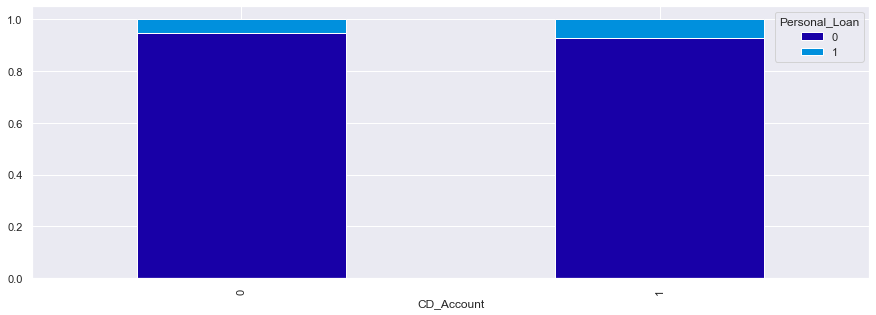

In [133]:
stacked_plot(misclassfied_lg["CD_Account"])

- Turn out that in the misclassfied samples, there are significantly lesser percentage of customers who have a certificate of deposit (CD) account with the bank and actually accepted loan, than the equivalent group in the original dataset.

#### Personal_Loan vs Using a CreditCard of other bank:

Personal_Loan    0   1  All
CreditCard                 
0              441  27  468
1              132   7  139
All            573  34  607
--------------------------------------------------------------------------------------------------------------


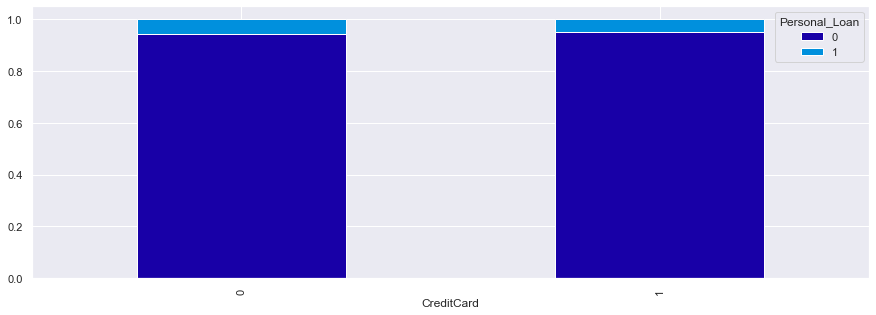

In [134]:
stacked_plot(misclassfied_lg["CreditCard"])

- Both classes of customers who use or never a credit card issued by any other Bank have less percentage of those who aactually accepted personal loans as compared with the original dataset.

### 2) Decision Tree Classifier model:

In [135]:
# Defining X and Y variables
X_DTree = df_customers.drop(["Personal_Loan"], axis=1)
y_DTree = df_customers["Personal_Loan"]

In [136]:
# find the ncorrectly predicted or misclassified samples
pred_y_lg = best_model.predict(X_DTree)

# we will do EDA on the samples before scaling was applied
misclassfied_DTree = df_customers[pred_y_lg != y_DTree]
misclassfied_DTree.head()

,Age,Income,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,Region_Middle_California,Region_Northern_California
12,48,114,2,3.80000,3,0,0,1,0,0,0,1,0
73,41,85,1,4.00000,3,0,0,0,0,1,1,0,1
82,41,82,1,4.00000,3,0,0,0,0,1,0,1,0
85,27,109,4,1.80000,3,0,0,0,0,0,0,1,0
89,25,113,4,2.30000,3,0,0,0,0,0,1,1,0


In [137]:
misclassfied_DTree.shape

(247, 13)

In [138]:
misclassfied_DTree[con_col].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,247.00000,44.60324,11.31068,25.00000,35.50000,43.00000,54.00000,67.00000
Income,247.00000,90.59919,17.68070,51.00000,79.00000,92.00000,109.00000,115.00000
CCAvg,247.00000,2.99757,1.18421,0.10000,2.30000,3.20000,3.80000,6.30000
Mortgage,247.00000,66.64777,111.61065,0.00000,0.00000,0.00000,119.50000,408.00000


### Let's perform EDA on those variables being marked as important by Decision Tree Classifier:
### Univariate analysis

#### Observations on Income:

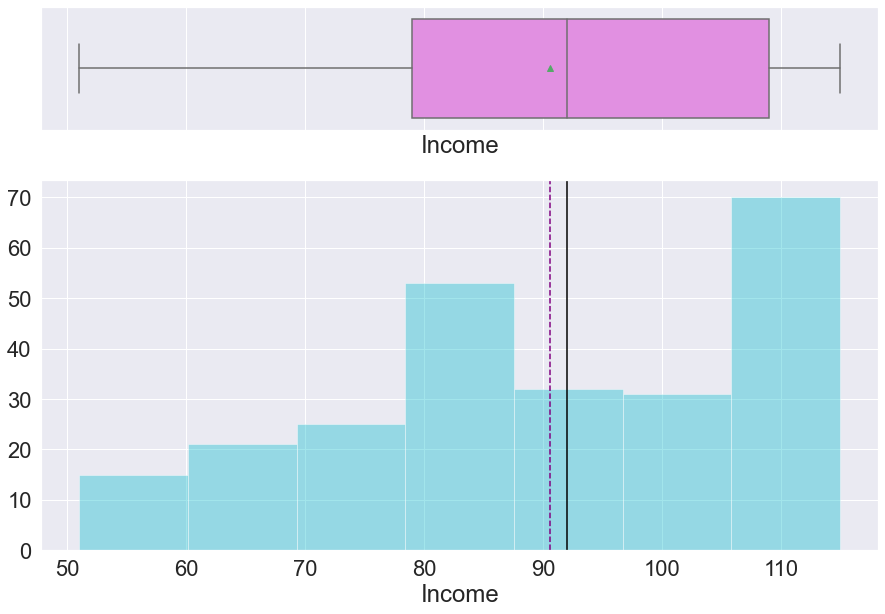

In [139]:
histogram_boxplot(misclassfied_DTree["Income"])

- The distribution of income variable in misclassified samples is left skewed.

#### Observations on CCAvg:

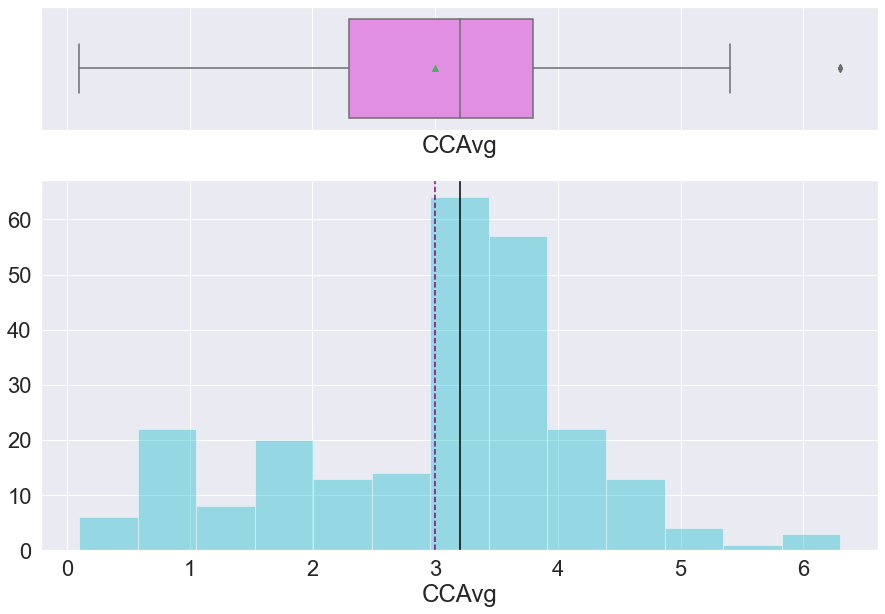

In [140]:
histogram_boxplot(misclassfied_DTree["CCAvg"])

#### Observations on the family size of customers:

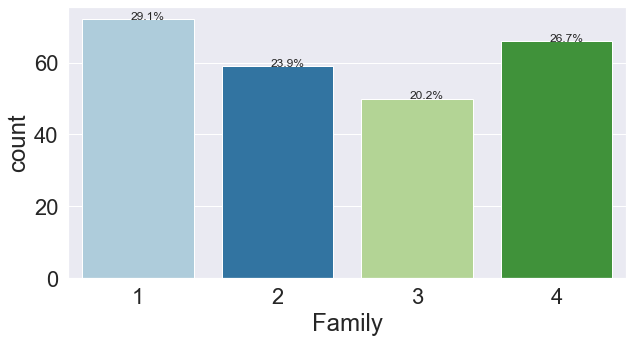

In [141]:
perc_on_bar(misclassfied_DTree["Family"])

#### Observations on education level of customers:

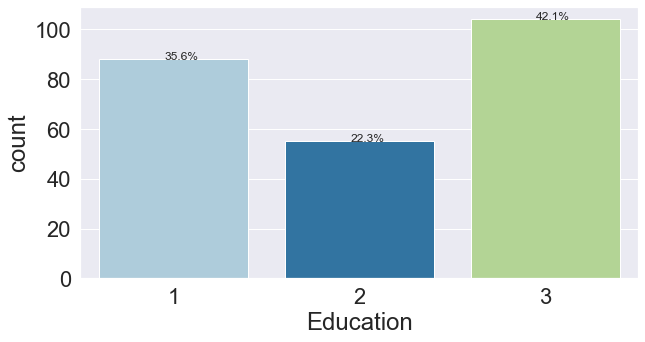

In [142]:
perc_on_bar(misclassfied_DTree["Education"])

### Bivariate Analysis

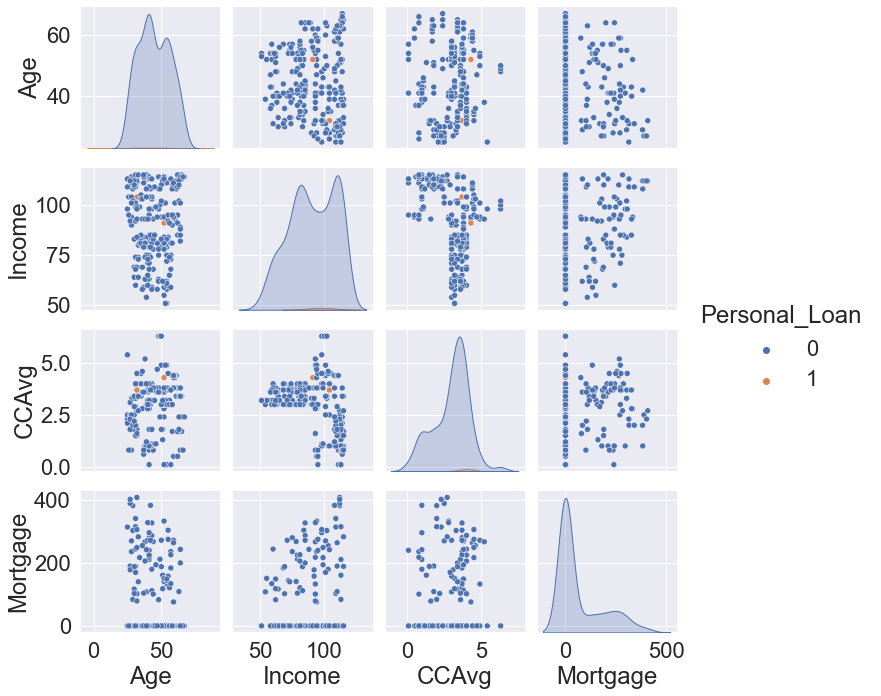

In [143]:
# check the linear relationships of numerical variables
con_col.append("Personal_Loan") #add "Personal_Loan" into continous column list to plot with  hue parameter
sns.pairplot(misclassfied_DTree[con_col],hue="Personal_Loan");

#### Personal_Loan vs Family:

Personal_Loan    0  1  All
Family                    
1               71  1   72
2               58  1   59
3               50  0   50
4               66  0   66
All            245  2  247
--------------------------------------------------------------------------------------------------------------


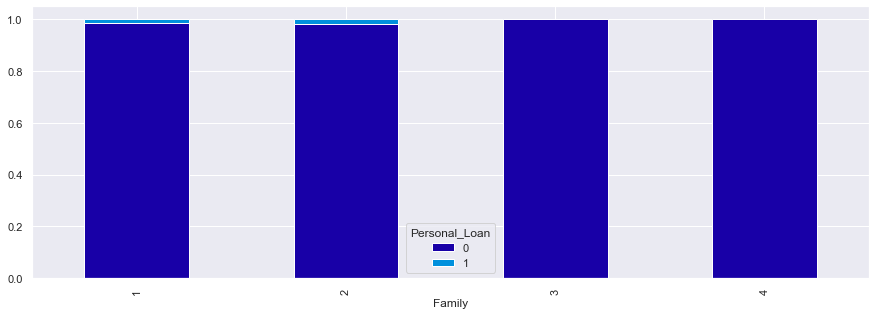

In [144]:
stacked_plot(misclassfied_DTree["Family"])

- the misclassified samples showed a different pattern as compared with Logistic Regression Model.

#### Personal_Loan vs Education:

Personal_Loan    0  1  All
Education                 
1               87  1   88
2               54  1   55
3              104  0  104
All            245  2  247
--------------------------------------------------------------------------------------------------------------


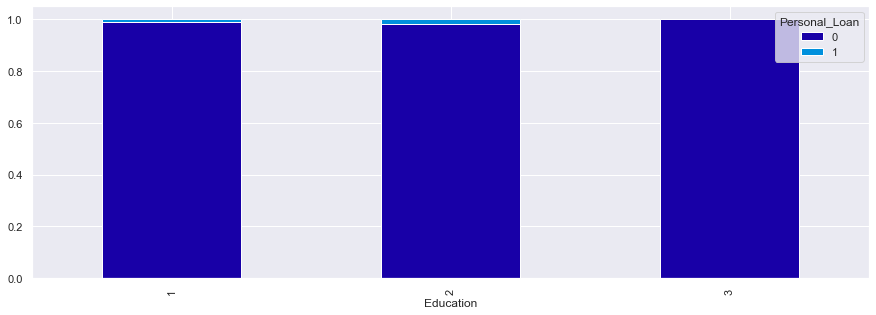

In [145]:
stacked_plot(misclassfied_DTree["Education"])

- Overall, the misclassified samples of Decision Tree Classifier model have some what different pattern pattern as compared with Logistic Regression Model.